# Libraries

In [199]:
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as Disp
from ipywidgets import widgets
from utils import *

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is Enabled")
    
import keract
import networkx as nx
from collections import deque, defaultdict
import sklearn
from sklearn import preprocessing
from typing import TypedDict, Optional, Union
from pprint import pprint
from grandalf.layouts import SugiyamaLayout
import grandalf
from PIL import Image

from pathlib import Path
import seaborn as sns
from tqdm import tqdm

import rich
from rich.progress import track
import pickle

from nltk.corpus import wordnet as wn

from PIL import Image, ImageDraw

# import onnx
# from onnx_tf.backend import prepare
# from onnx2keras import onnx_to_keras
# from onnx2tf import convert


# Dataset

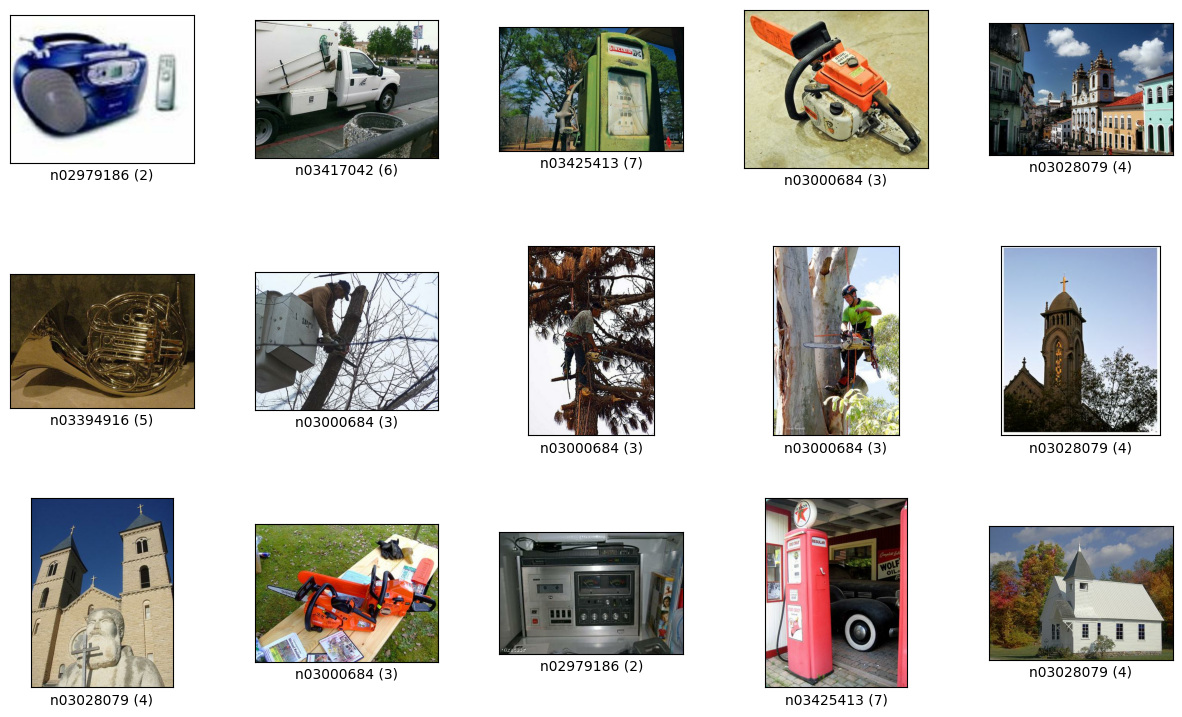

KeyboardInterrupt: 

In [200]:
imagenette, imagenette_info = tfds.load(
    'imagenette/320px-v2', 
    shuffle_files=False, 
    with_info=True,
    as_supervised=True,
    batch_size=None,
    data_dir='/run/media/insane/SSD Games/Tensorflow/tensorflow_datasets',
)

tfds.show_examples(imagenette['train'], imagenette_info, cols=5)

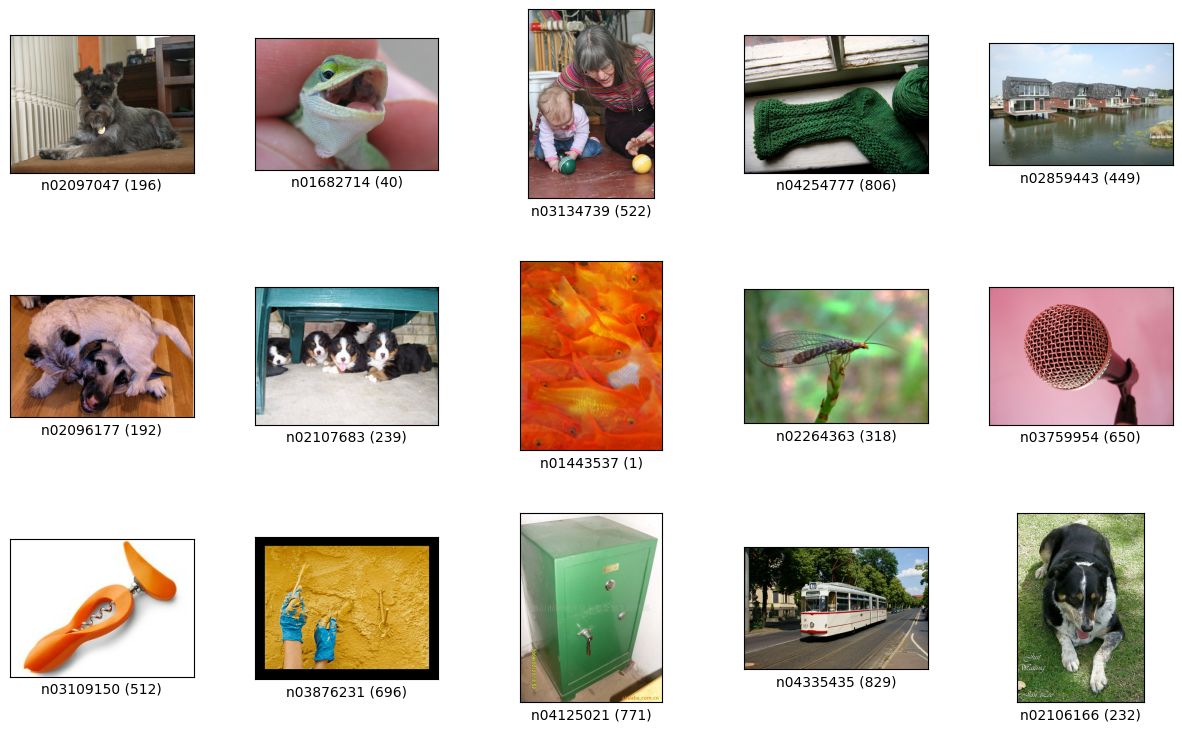

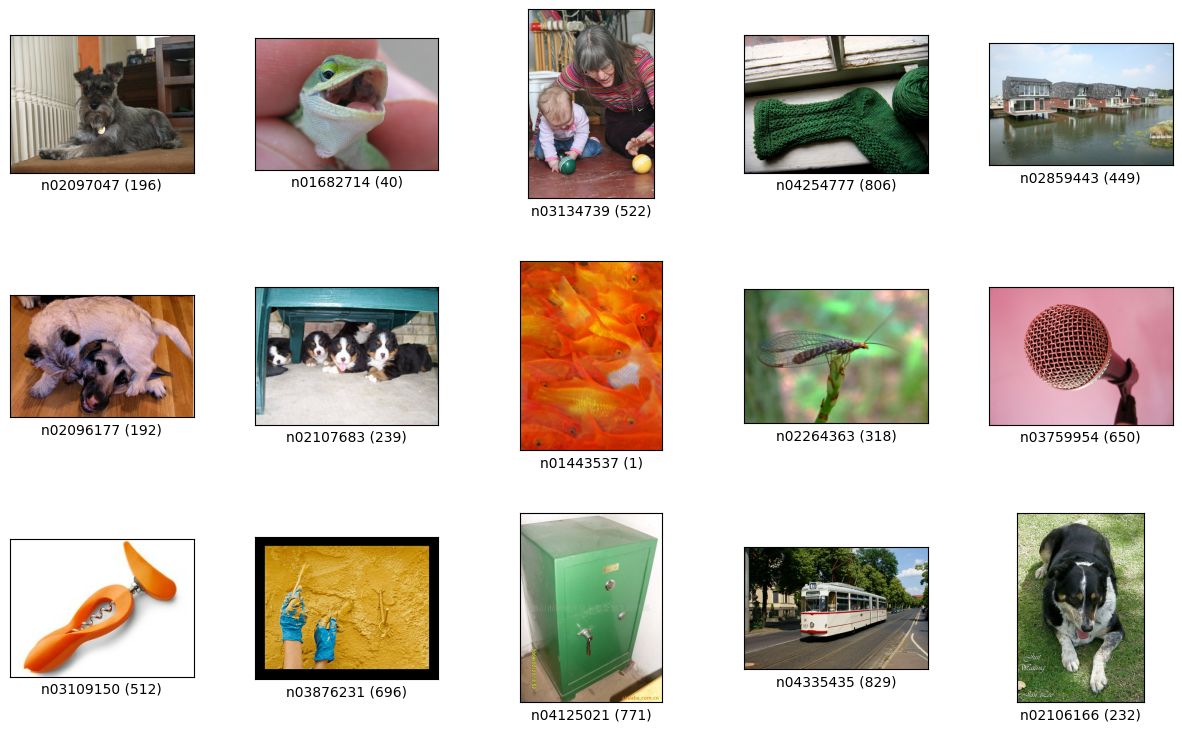

In [ ]:
imagenet, imagenet_info = tfds.load(
    'imagenet2012', 
    shuffle_files=False, 
    with_info=True,
    as_supervised=True,
    batch_size=None,
    data_dir='/run/media/insane/SSD Games/Tensorflow/tensorflow_datasets'
)

tfds.show_examples(imagenet['train'], imagenet_info, cols=5)

In [ ]:
ds = imagenette
ds_info = imagenette_info

In [ ]:
for image, label in ds['train'].shuffle(100):
    print(image.shape)
    print(ds_info.features['label'].names[label])
    break

(426, 320, 3)
n03425413


# Inception V3

![Inceptionv3_architecture.png](Inceptionv3_architecture.png)

In [ ]:
inception_v3 = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet'
)
inception_v3.compile(loss="categorical_crossentropy", optimizer="adam")

vgg = tf.keras.applications.vgg16.VGG16(
    weights='imagenet'
)

vgg.compile(loss="categorical_crossentropy", optimizer="adam")

model = vgg


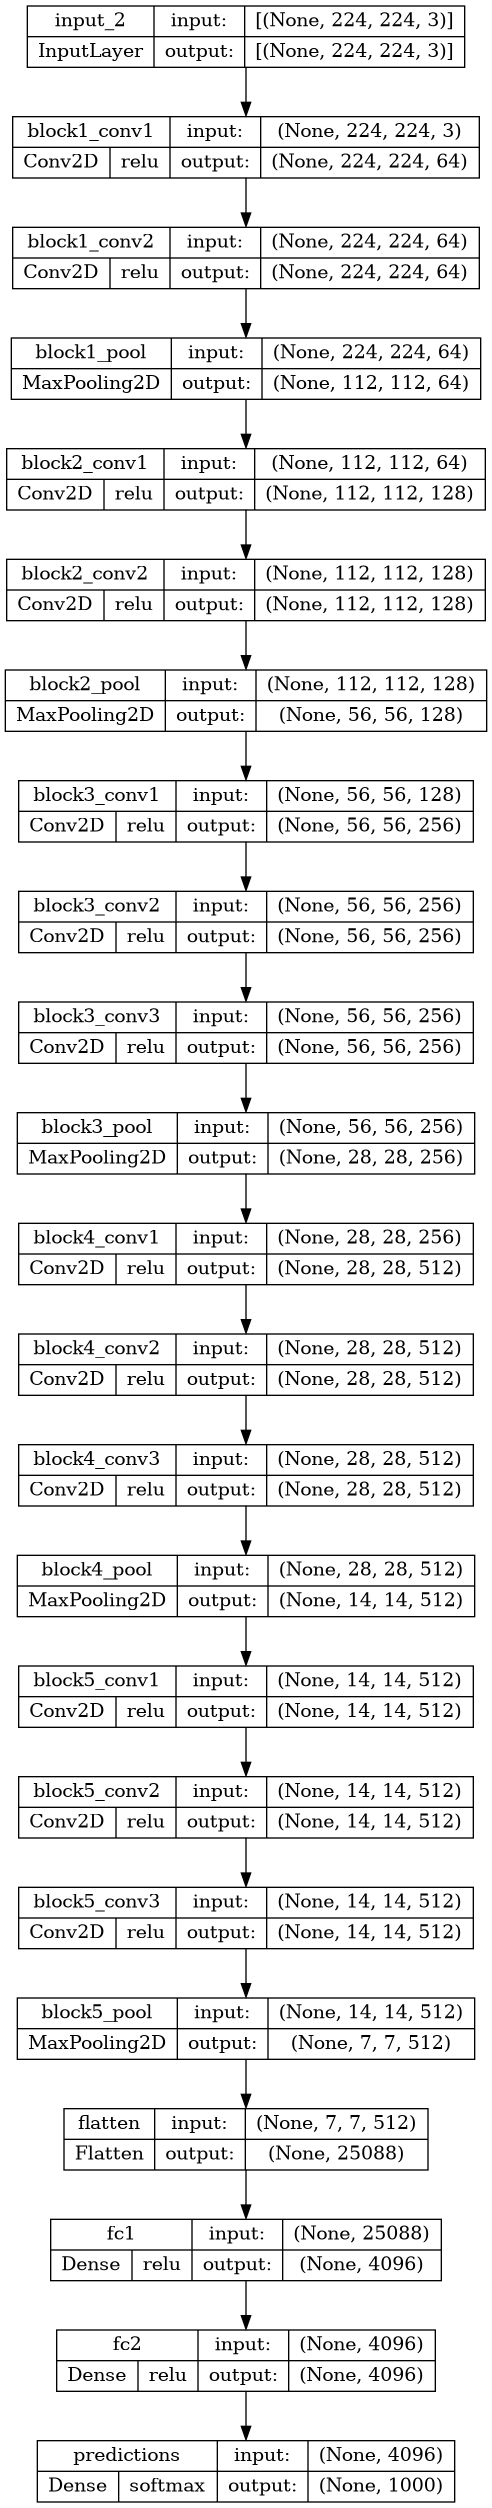

In [ ]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True,
    # show_dtype=True,
    # expand_nested=True,
    show_layer_activations=True
)

# Get Activation Pathways

In [ ]:
activation_pathway_full = model_to_graph(model)

In [ ]:
names = set()

for node, node_data in activation_pathway_full.nodes(data=True):
    names.add(node_data['layer_type'])

names

{'Conv2D', 'Dense', 'Flatten', 'InputLayer', 'MaxPooling2D'}

In [ ]:
simple_activation_pathway_full = remove_intermediate_node(activation_pathway_full, lambda node: activation_pathway_full.nodes[node]['layer_type'] not in ['Conv2D', 'Dense', 'InputLayer', 'Concatenate'])

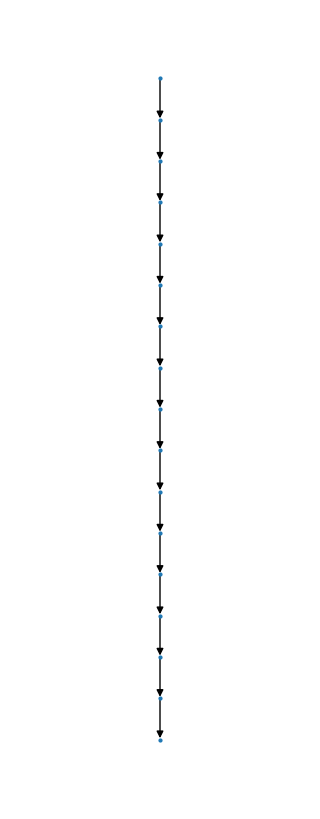

In [ ]:
def get_model_layout(G):
    # TODO: Work on getting a better layout

    # Naive layout
    # pos = {}
    # input_node, _ = next(node for node in G.nodes(data=True) if node[1]['layer_type'] == 'InputLayer')
    # G.nodes[input_node]['level'] = 0
    # tree_depth = 0
    # for node in nx.topological_sort(G):
    #     if G.nodes[node]['layer_type'] == 'InputLayer':
    #         continue
    #     level = max(
    #         G.nodes[predecessor]['level'] 
    #         for predecessor in G.predecessors(node)
    #     ) + 1
    #     G.nodes[node]['level'] = level
    #     tree_depth = max(tree_depth, level)
    # pos = nx.multipartite_layout(G, subset_key="level", align='horizontal', scale=-1)


    # Get nodes by level
    # nodes_by_level = [[] for tree_depth in range(tree_depth + 1)]

    # for node, node_data in simple_activation_pathway_full.nodes(data=True):
    #     nodes_by_level[node_data['level']].append(node)

    # [[nx.get_node_attributes(simple_activation_pathway_full, 'name')[node] for node in nodes] for nodes in nodes_by_level]


    # Sugiyama Layout from grandalf library
    g = grandalf.utils.convert_nextworkx_graph_to_grandalf(G)
    for v in g.V(): v.view = type("defaultview", (object,), {"w": 10, "h": 10})
    sug = SugiyamaLayout(g.C[0])
    sug.init_all()
    sug.draw() # This only calculated the positions for each node.
    pos = {v.data: (v.view.xy[0], -v.view.xy[1]) for v in g.C[0].sV} # Extracts the positions
    return pos

plt.figure(figsize=(3,8))
nx.draw(simple_activation_pathway_full, pos=get_model_layout(simple_activation_pathway_full), node_size=4)
plt.show()

# Get each layer output

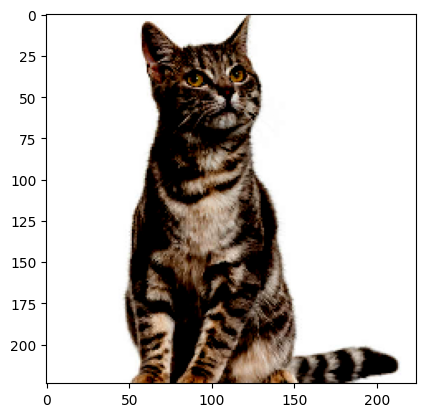

In [ ]:
input_img = Image.open("cat.jpg")
input_img = np.array(input_img)
input_img, label = preprocess((input_img, None), size=model.input.shape[1:3].as_list())

plt.imshow(input_img)

In [ ]:
input_img = tf.reshape(input_img, [1, *input_img.shape]).numpy()
pred = model(input_img)

print('Predicted', pred_to_name(tf.math.argmax(pred[0]).numpy()))
print('True Cat')

Predicted Egyptian_cat
True Cat


In [ ]:
# layers = ['conv2d_6', 'conv2d_93']
layers = None

activations = keract.get_activations(model, input_img, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)

activations.keys()

odict_keys(['input_2', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions'])

In [ ]:
# summary_fn = lambda x: np.percentile(np.abs(x), 70, axis=range(len(x.shape)-1))
# summary_fn = lambda x: np.mean(np.abs(x), axis=tuple(range(len(x.shape)-1)))
summary_fn_image = lambda x: np.linalg.norm(x, axis=tuple(range(1, len(x.shape)-1)), ord=2)
# summary_fn = lambda x: np.percentile(np.abs(x), 70, axis=range(1, len(x.shape)-1))

summary_fn_dense = lambda x: x

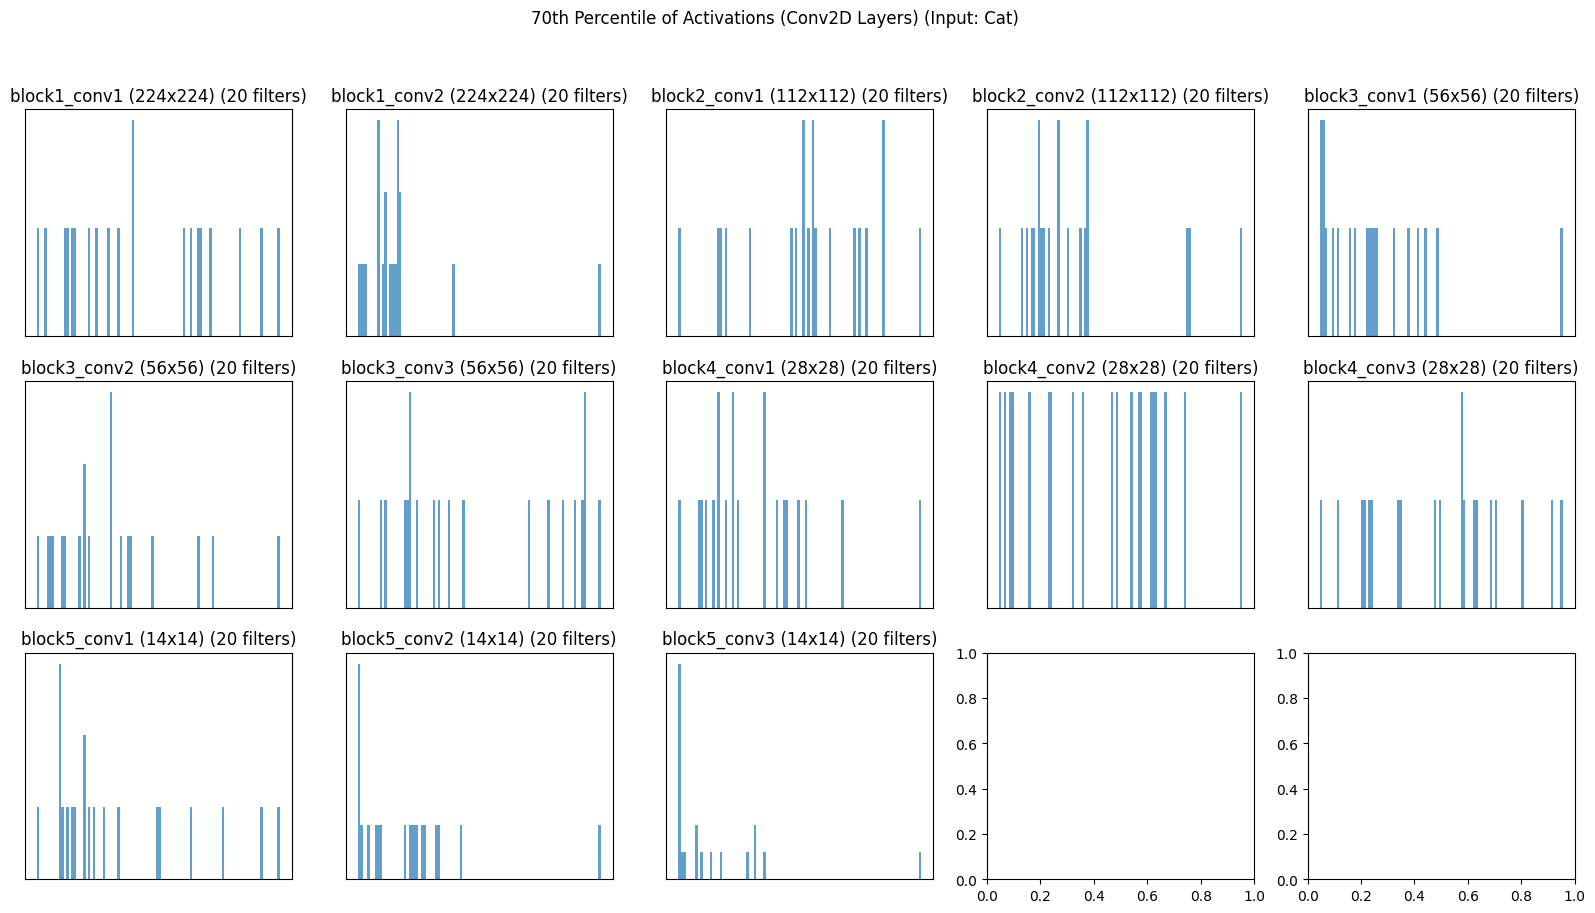

In [ ]:
conv2D_activations = [layer for layer in activations if 'conv' in layer]

cols = 5
rows = len(conv2D_activations) // cols + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 10),
    # sharex=True,
    # sharey=True
)
axes = axes.flatten()
fig.suptitle("70th Percentile of Activations (Conv2D Layers) (Input: Cat)")
# fig.suptitle("Mean of Activations (Conv2D Layers) (Input: Cat)")
# fig.suptitle("Median of Activations (Conv2D Layers) (Input: Cat)")

for layer, ax in zip(conv2D_activations, axes):
    summary = summary_fn_image(activations[layer])[0][:20]
    ax.hist(summary, bins=100, alpha=0.7)
    ax.set_title(f"{layer} ({activations[layer].shape[1]}x{activations[layer].shape[2]}) ({summary.shape[0]} filters)")

    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

/tmp/ipykernel_2976/3226390771.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)


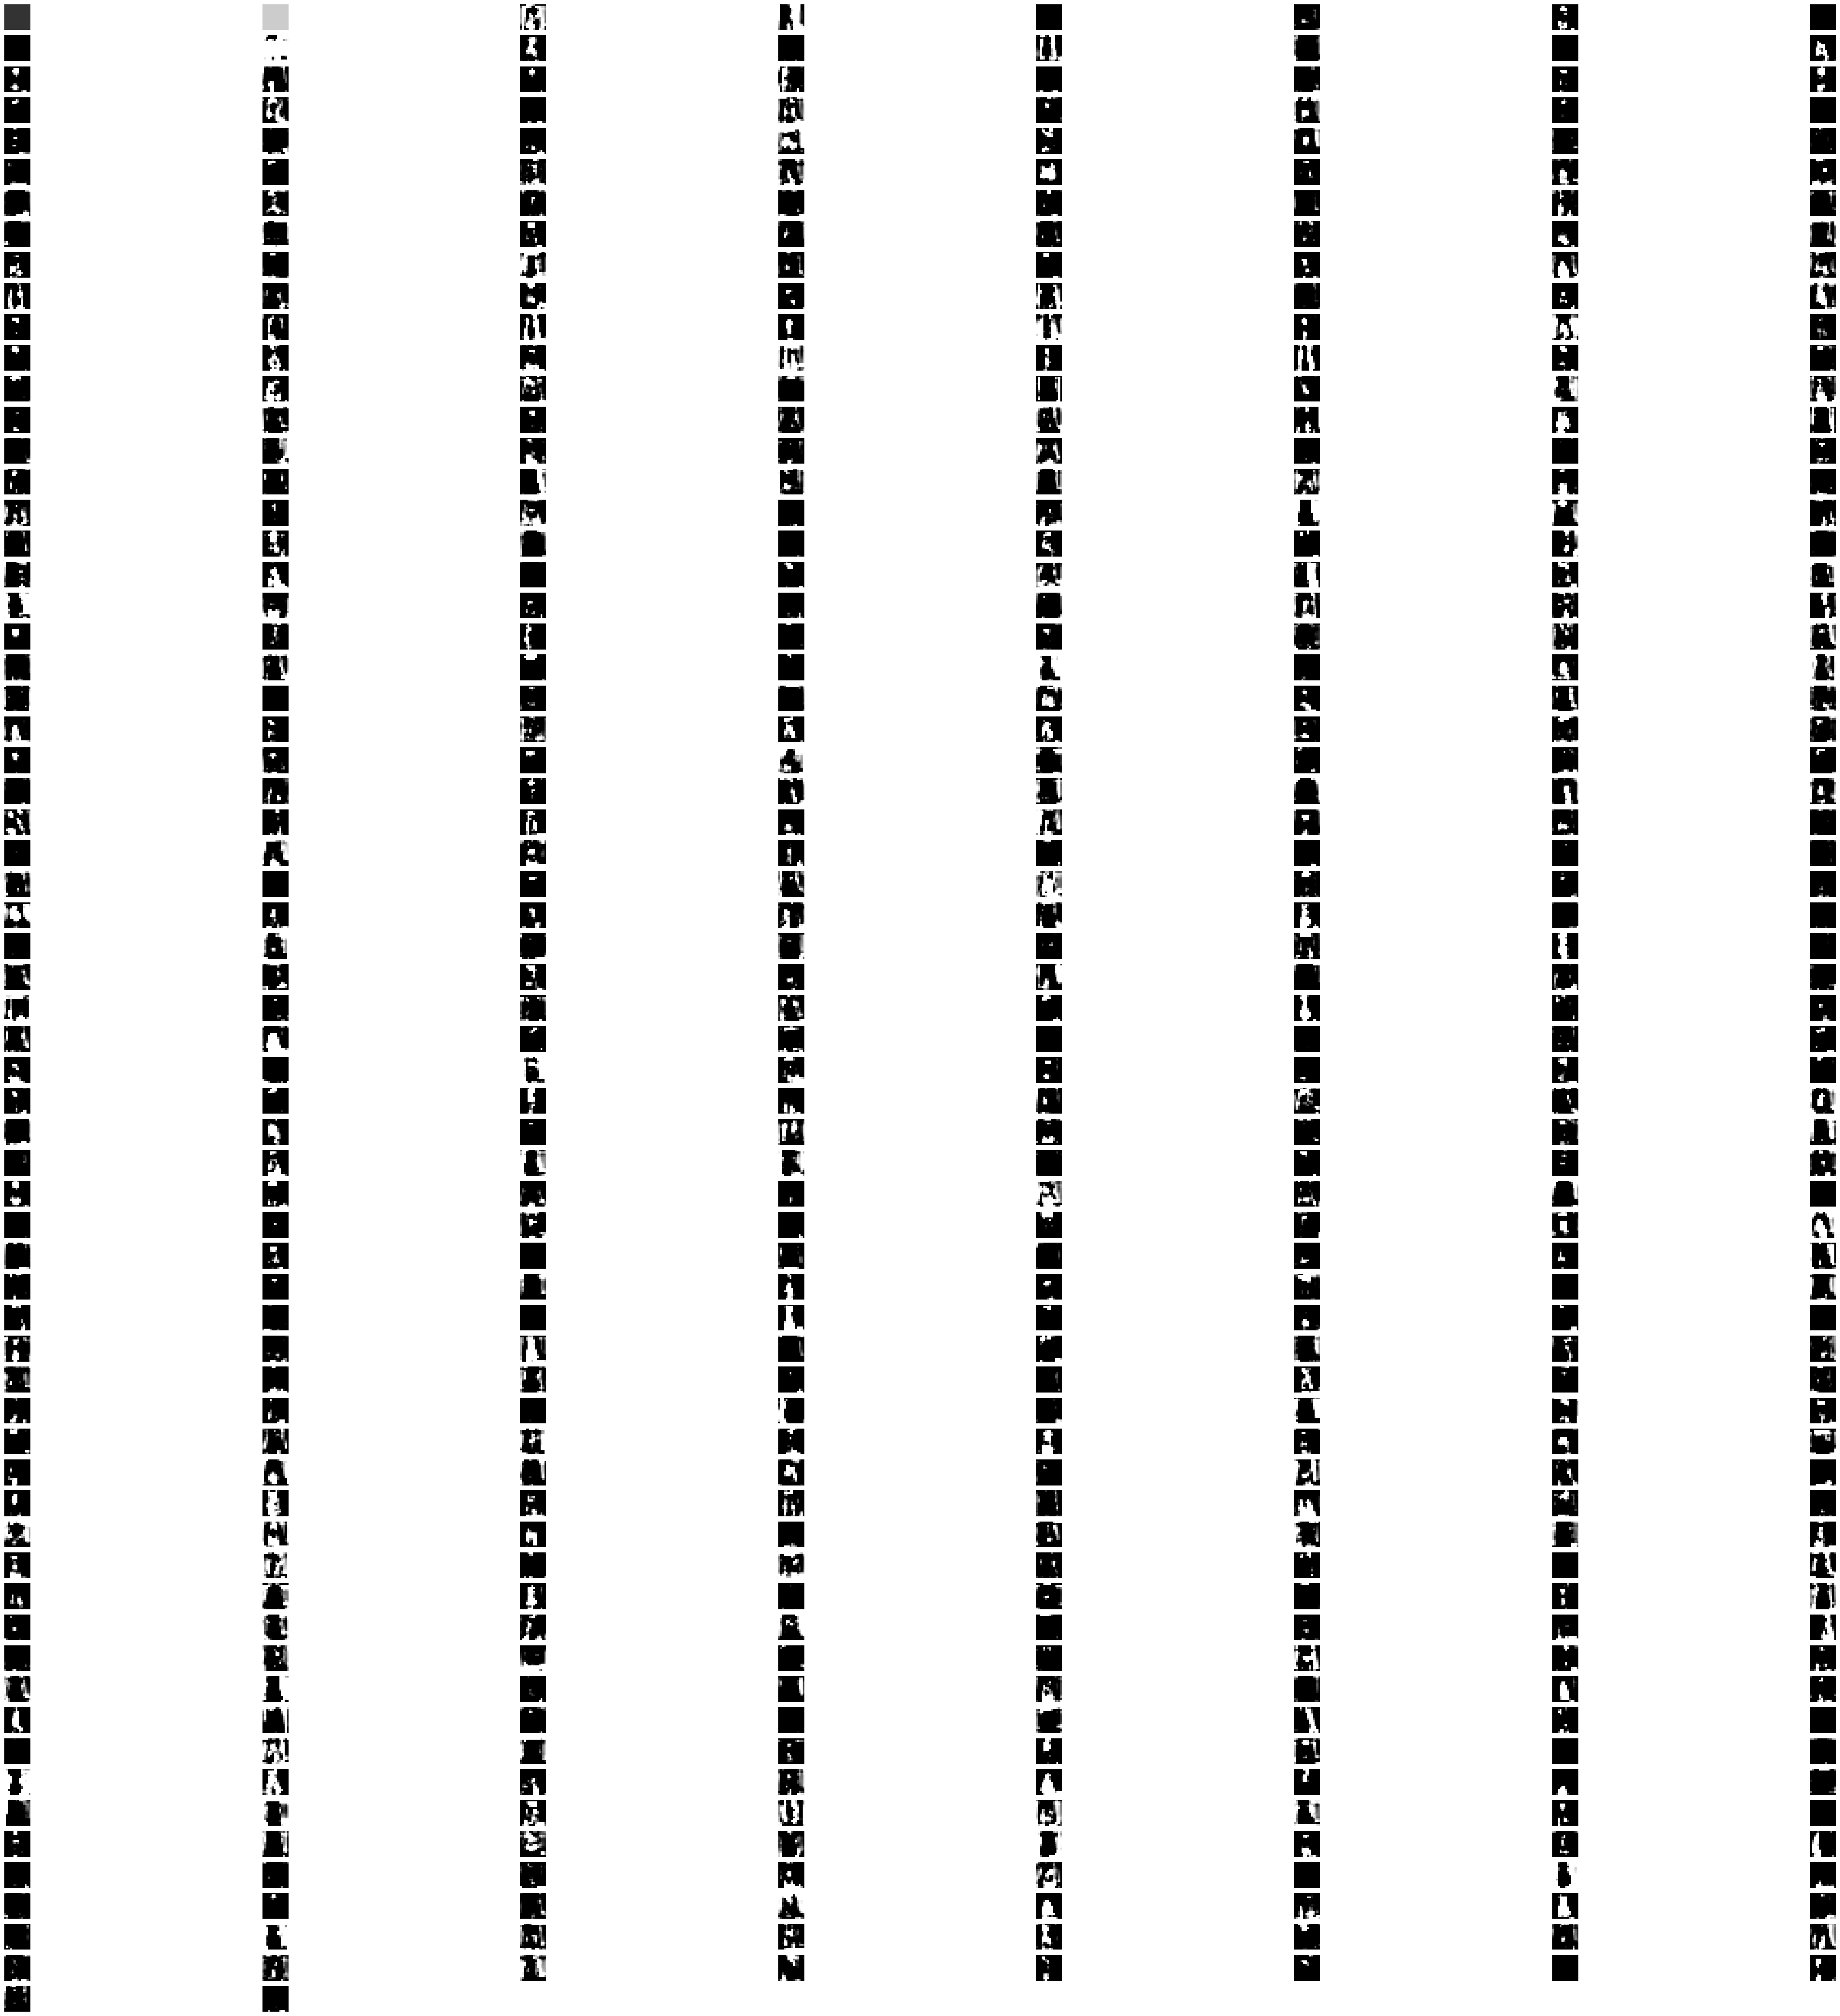

In [ ]:
layer = 'block5_conv2'
nrows = 8
cur_activations = np.abs(activations[layer])
cur_activations = (cur_activations - np.percentile(cur_activations, 10)) / (np.percentile(cur_activations, 90) - np.percentile(cur_activations, 10))
cur_activations = np.concatenate([(np.ones((*cur_activations.shape[:3],1))*0.2), (np.ones((*cur_activations.shape[:3],1))*0.8), cur_activations], axis=3)

# Plot all the images from layer in grid with nrows columns
fig, ax = plt.subplots(figsize=(60, 60))
for i in range(cur_activations.shape[3]):
    ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)
    ax.imshow(
        cur_activations[0,:,:,i],
        interpolation='nearest',
        cmap='gray',
        vmin=0,
        vmax=1,
    )
    ax.axis('off')
plt.show()


block5_conv2 (1, 56, 56, 256) 


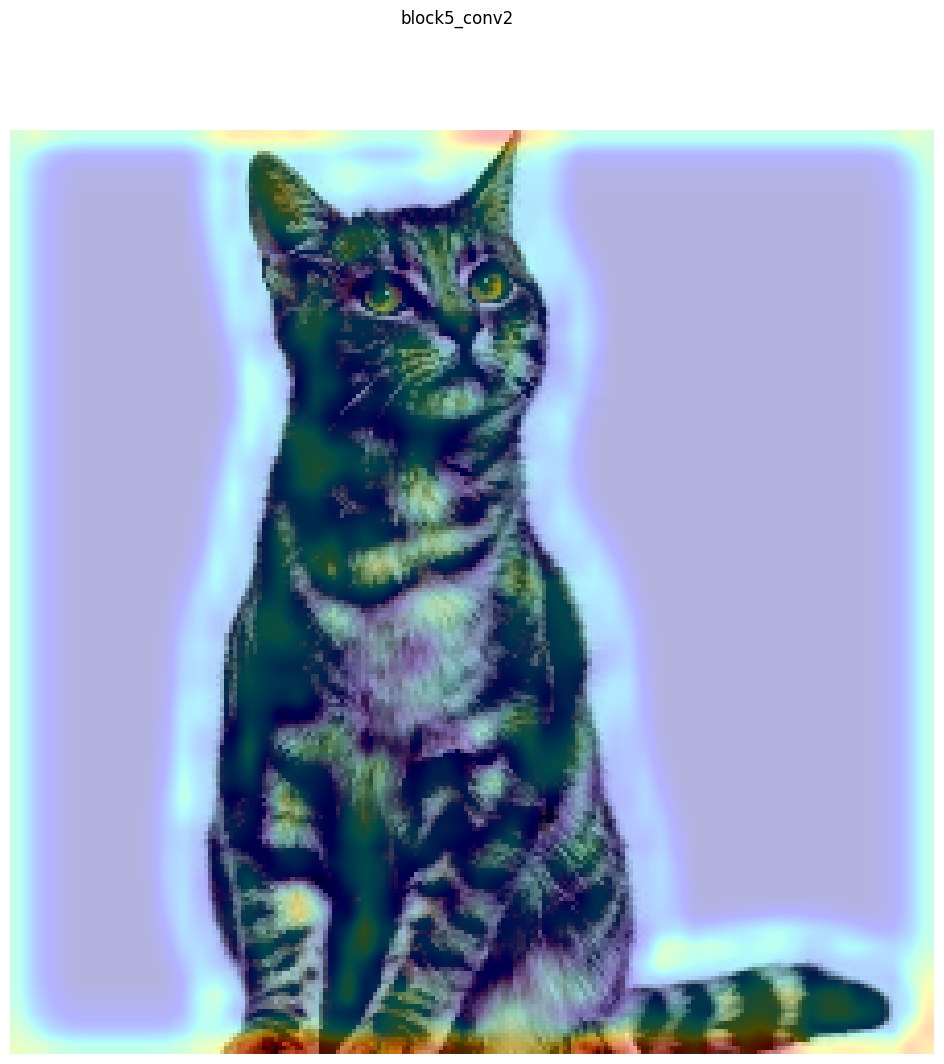

In [ ]:
keract.display_heatmaps({layer: np.array([activations['block3_conv2'][0]])}, input_img[0], fix=False, merge_filters=True)

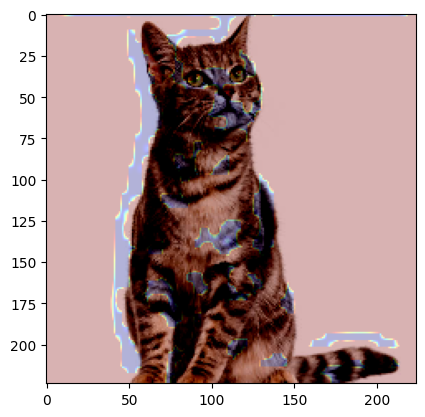

In [ ]:
def get_activation_overlay(input_img, activation, cmap=plt.cm.jet, alpha=0.3):
    act_img = Image.fromarray(act)
    act_img = act_img.resize((input_img.shape[1], input_img.shape[0]), Image.BILINEAR)
    act_img = np.array(act_img)
    act_rgb = cmap(act_img)

    # Blend act_img to original image
    out_img = np.zeros(input_img.shape, dtype=input_img.dtype)
    out_img[:,:,:] = ((1-alpha) * input_img[:,:,:] + alpha * act_rgb[:,:,:3]).astype(input_img.dtype)
    return out_img


act = activations['block3_conv2'][0,:,:,5]
out_img = get_activation_overlay(input_img[0], act, cmap=plt.cm.jet, alpha=0.3)

plt.imshow(out_img)

# Filtering activation layers

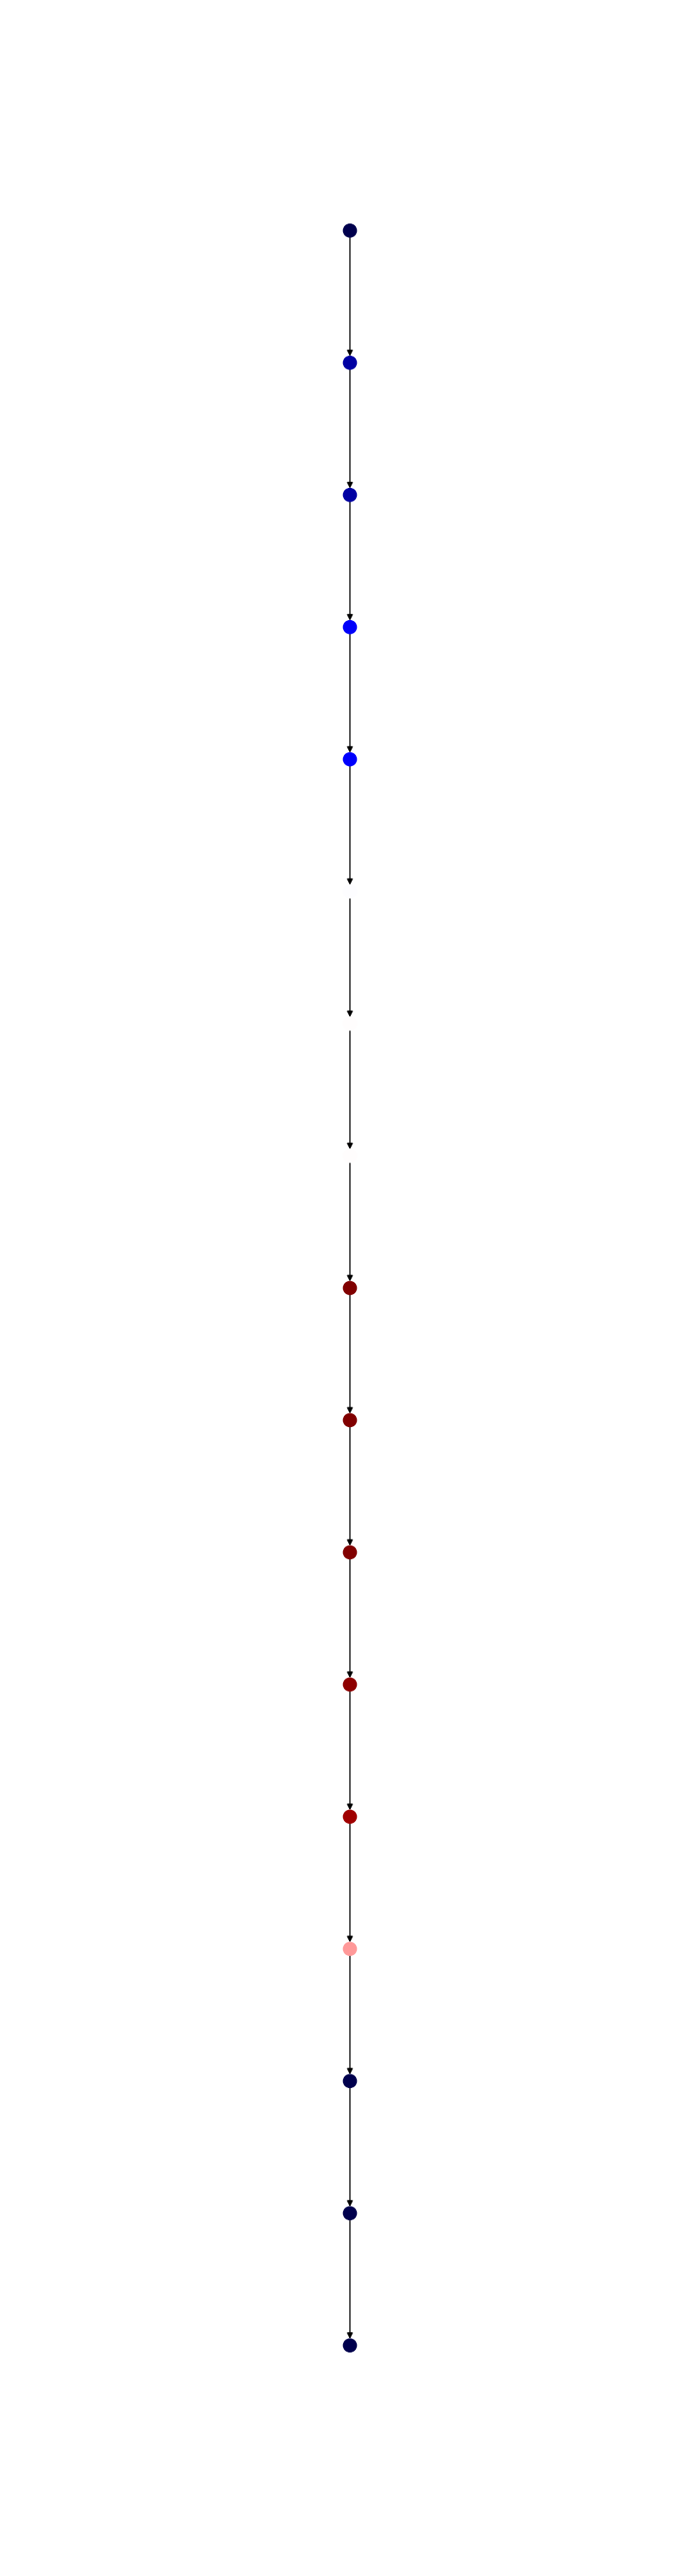

In [ ]:
THRESHOLD = 0.5
TOP_BOT_CUT = 0

simple_activation_pathway_full_img1 = simple_activation_pathway_full.copy()

for node, data in simple_activation_pathway_full_img1.nodes(data=True):
    if 'conv' in data['name'] or 'mixed' in data['name']:
        cur_activations = activations[data['name']]
        # cur_activations = np.clip((cur_activations - np.percentile(cur_activations, TOP_BOT_CUT)) / (np.percentile(cur_activations, 100 - TOP_BOT_CUT) - np.percentile(cur_activations, TOP_BOT_CUT)), 0, 1)
        values = summary_fn_image(cur_activations)

        dynamic_threshold = np.percentile(values, 100 * THRESHOLD)

        # values = values > dynamic_threshold
        values = values > THRESHOLD

        simple_activation_pathway_full_img1.nodes[node]['activated'] = values
    else:
        simple_activation_pathway_full_img1.nodes[node]['activated'] = np.array([True])


plt.figure(figsize=(8,30))
activated_count = np.array([data['activated'].sum()/len(data['activated']) for node, data in simple_activation_pathway_full_img1.nodes(data=True)])
activated_count = (activated_count - activated_count.min()) / (activated_count.max() - activated_count.min())

cmap = list(map(mpl.colormaps['seismic'], activated_count))
nx.draw(
    simple_activation_pathway_full_img1,
    pos=get_model_layout(simple_activation_pathway_full_img1),
    node_size=120,
    node_color=cmap,
    # labels=nx.get_node_attributes(simple_activation_pathway_full_img1, 'name'),
    # connectionstyle="arc3,rad=0.1"
)
plt.show()

['input_2   1/1', 'block1_conv1   64/1', 'block1_conv2   64/1', 'block2_conv1   126/1', 'block2_conv2   128/1', 'block3_conv1   255/1', 'block3_conv2   256/1', 'block3_conv3   256/1', 'block4_conv1   510/1', 'block4_conv2   511/1', 'block4_conv3   509/1', 'block5_conv1   496/1', 'block5_conv2   478/1', 'block5_conv3   307/1', 'fc1   1/1', 'fc2   1/1', 'predictions   1/1']


/tmp/ipykernel_2976/2341248753.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


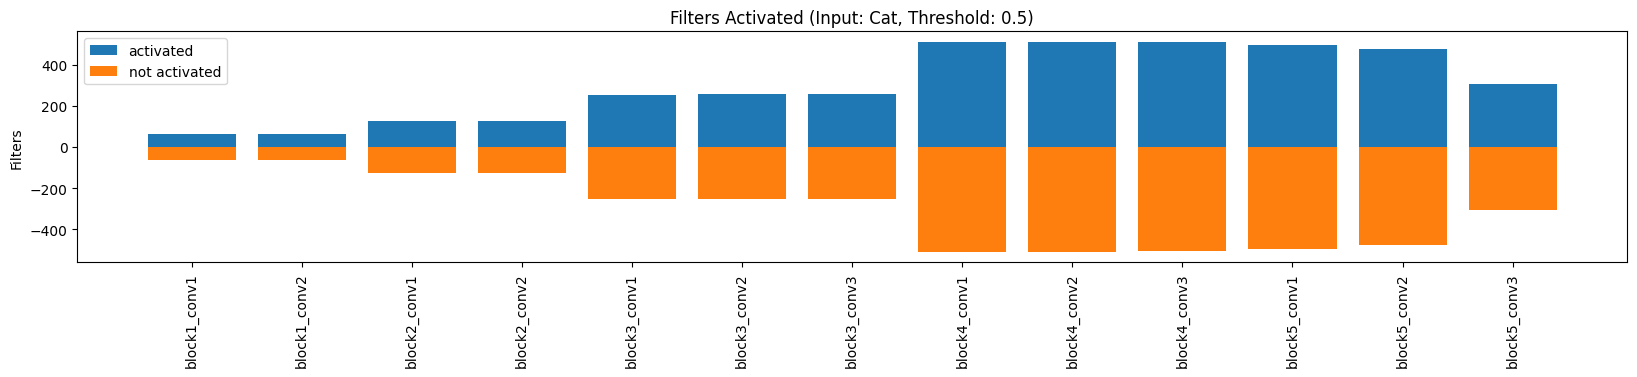

In [ ]:
print([f"{data['name']}   {data['activated'].sum()}/{len(data['activated'])}" for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data])
activated = {data['name']: (data['activated'].sum(), len(data['activated'])-data['activated'].sum()) for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data}

conv2D_activated = {k: v for k, v in activated.items() if 'conv' in k}

labels = [k for k in conv2D_activated.keys()]
activated = [v[0] for v in conv2D_activated.values()]
deactivated = [v[1] for v in conv2D_activated.values()]

fig, ax = plt.subplots(figsize=(20, 3))
ax.bar(labels, activated, label="activated")
ax.bar(labels, deactivated, label="not activated")
ax.set_ylabel("Filters")
ax.set_xticklabels(labels, rotation=90)
ax.set_title(f"Filters Activated (Input: Cat, Threshold: {THRESHOLD})")
ax.legend()
plt.show()

In [ ]:
def compare_activation_layer(layer1_activation_summary, layer2_activation_summary):
    return np.sqrt(((layer1_activation_summary - layer2_activation_summary)*(layer1_activation_summary - layer2_activation_summary)).sum())

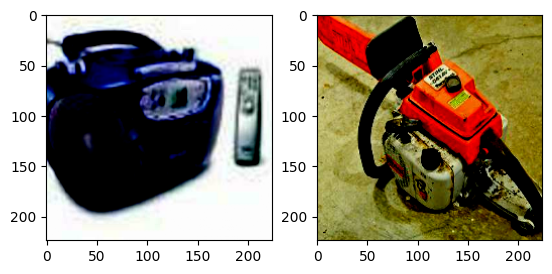

2 3


In [ ]:
example_img1, example_label1 = get_example(ds['train'])
example_img2, example_label2 = get_example(ds['train'])

example_img1, _ = preprocess((example_img1, None), size=model.input.shape[1:3].as_list())
example_img2, _ = preprocess((example_img2, None), size=model.input.shape[1:3].as_list())
plt.subplot(121)
plt.imshow(example_img1)
plt.subplot(122)
plt.imshow(example_img2)
plt.show()

print(example_label1, example_label2)

19551.0837059021


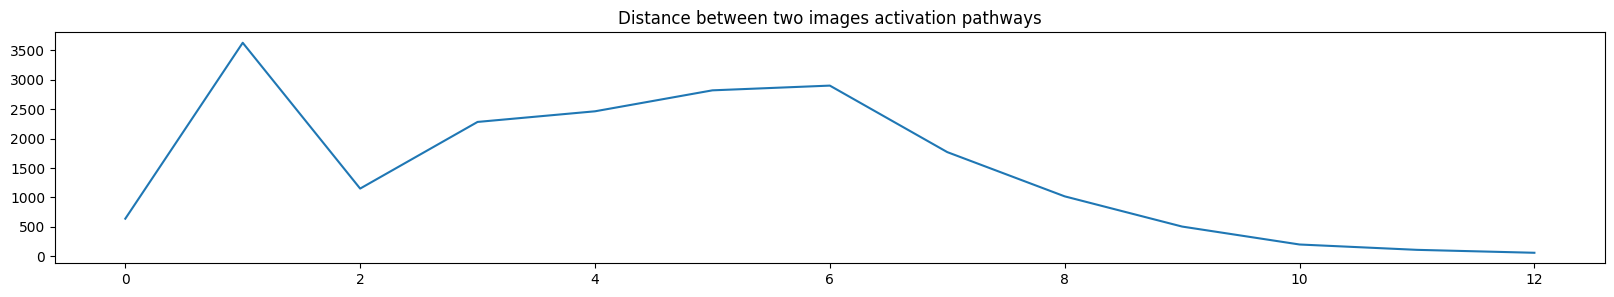

In [ ]:
layers = None

activations1 = keract.get_activations(model, np.array([example_img1]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
activations2 = keract.get_activations(model, np.array([example_img2]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)


dist = {f"{i_name}-{j_name}": compare_activation_layer(summary_fn_image(layer_i), summary_fn_image(layer_j)) for i_name, layer_i in activations1.items() for j_name, layer_j in activations2.items() if ('conv' in i_name or 'mixed' in i_name) and i_name == j_name}

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(dist.values())
# ax.set_ylim(0, 10)
ax.set_title("Distance between two images activation pathways")
print(sum(dist.values()))

In [ ]:
dist

{'block1_conv1-block1_conv1': 638.9743,
 'block1_conv2-block1_conv2': 3628.7651,
 'block2_conv1-block2_conv1': 1150.7788,
 'block2_conv2-block2_conv2': 2283.5405,
 'block3_conv1-block3_conv1': 2464.1921,
 'block3_conv2-block3_conv2': 2820.4343,
 'block3_conv3-block3_conv3': 2900.8113,
 'block4_conv1-block4_conv1': 1770.584,
 'block4_conv2-block4_conv2': 1018.56305,
 'block4_conv3-block4_conv3': 505.11392,
 'block5_conv1-block5_conv1': 200.3175,
 'block5_conv2-block5_conv2': 109.408165,
 'block5_conv3-block5_conv3': 59.60056}

# Get summary for whole dataset

In [ ]:
processed_ds = ds['train'].map(
    lambda x,y: preprocess((x,y), size=model.input.shape[1:3].as_list()),
)
processed_ds = processed_ds.batch(32)
processed_ds = processed_ds.prefetch(tf.data.experimental.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
layers = list(filter(lambda l: 'conv' in l or 'mixed' in l, map(lambda l: l.name, model.layers)))

for img_batch, label_batch in processed_ds:
    activations = keract.get_activations(model, img_batch, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
    print(activations[layers[0]].shape)
    print(summary_fn_image(activations[layers[0]]).shape)
    
    # pred = inception_v3.predict(img_batch)
    # print(np.sum(pred.argmax(axis=1) == label_batch.numpy()))
    break

(32, 224, 224, 64)
(32, 64)


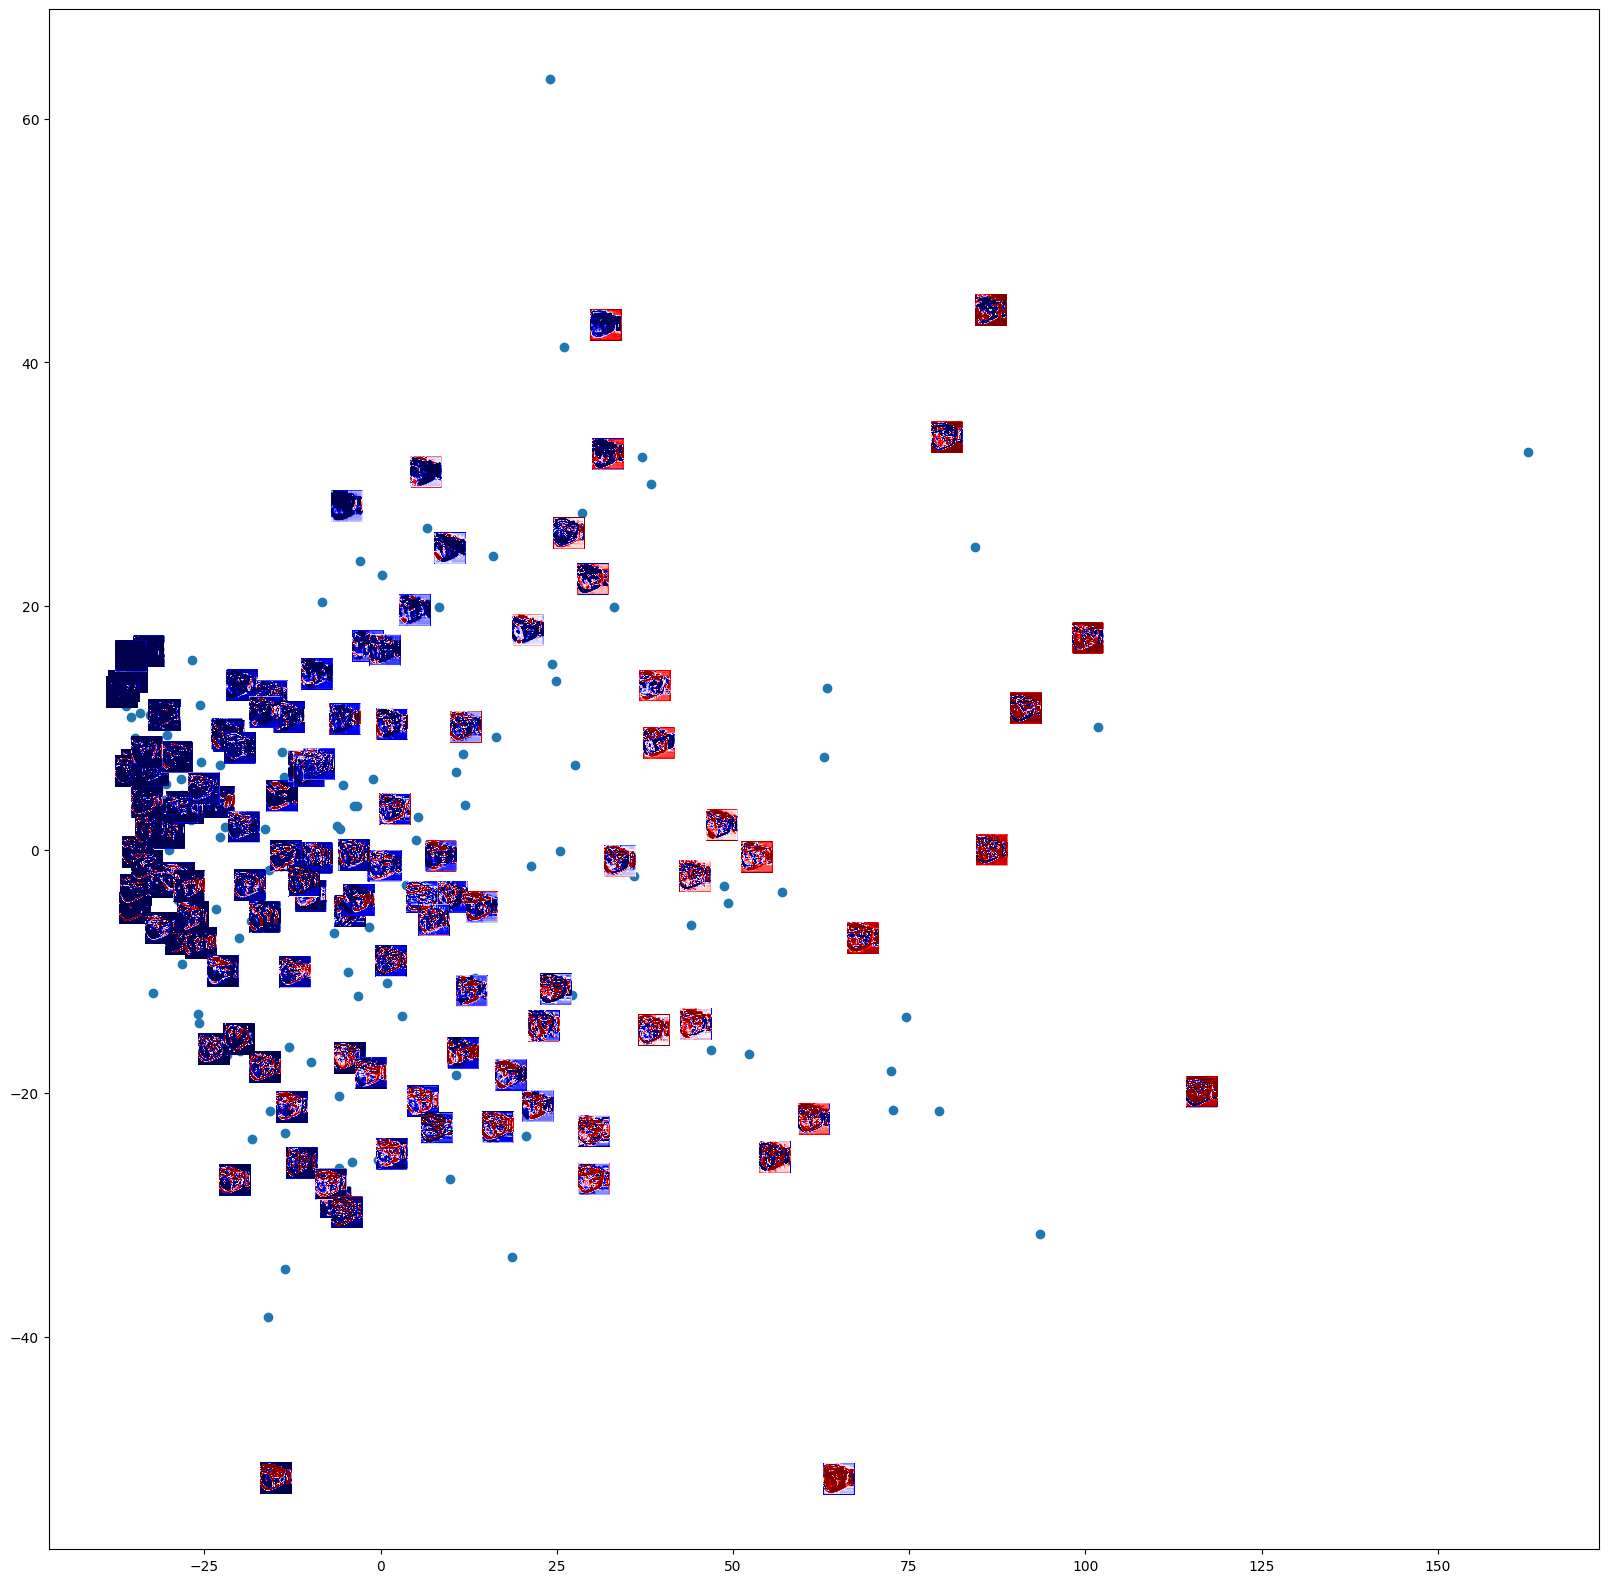

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

LOW_PERCENT = 10
HIGH_PERCENT = 90
img_size_zoom = 0.4
threshold = 7
thresholded = summary_fn_image(np.array([activations[layer][0]]))[0] > threshold

layer = 'block3_conv1'

data = np.moveaxis(activations[layer][0], 2, 0)
train = data.reshape((data.shape[0], -1))
train = StandardScaler().fit_transform(train)

pca = PCA(n_components=2)
pca_res = pca.fit_transform(train)
x = pca_res[:,0]
y = pca_res[:,1]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    if not thresholded[i]:
        continue
    offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
    img = offsetImg.get_children()[0]
    img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
    ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
    ax.add_artist(ab)

0.0 115.77761


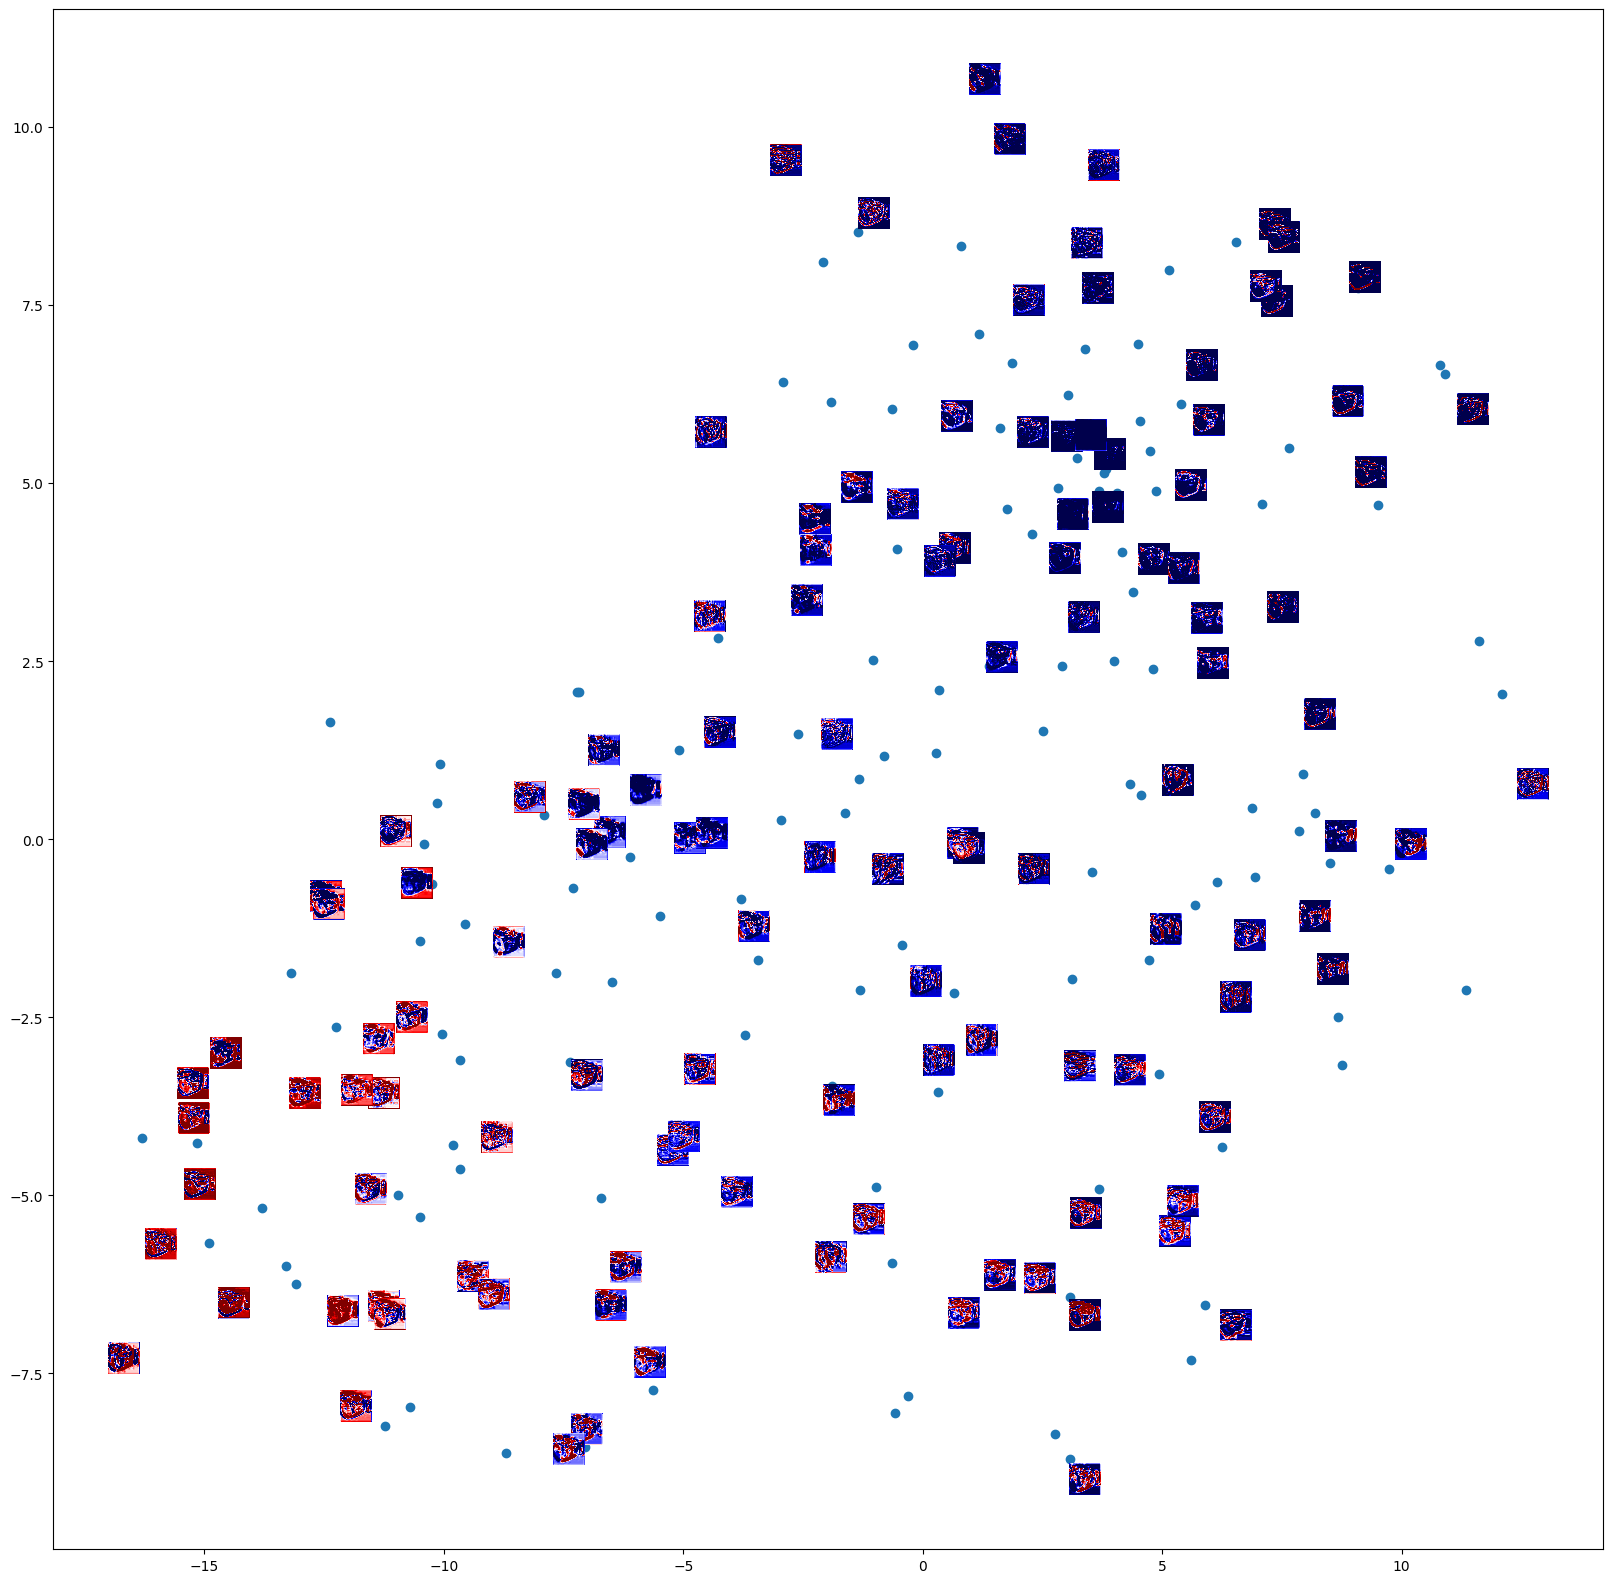

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=0, perplexity=30)
tsne_res = tsne.fit_transform(train)

x = tsne_res[:,0]
y = tsne_res[:,1]

print(data.min(), data.max())

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    if not thresholded[i]:
        continue
    offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
    img = offsetImg.get_children()[0]
    img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
    ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
    ax.add_artist(ab)

In [ ]:
# umap library is still not stable to flawlessy work on all environments
# import umap
# reducer = umap.UMAP(
#     n_neighbors=50
# )

# umap_res = reducer.fit_transform(train)

# x = umap_res[:,0]
# y = umap_res[:,1]

# fig, ax = plt.subplots(figsize=(20, 20))
# ax.scatter(x, y) 

# for i, (x0, y0) in enumerate(zip(x, y)):
#     if not thresholded[i]:
#         continue
#     offsetImg = OffsetImage(data[i], zoom=img_size_zoom, cmap='seismic')
#     img = offsetImg.get_children()[0]
#     img.set_clim(vmin=np.percentile(data.flatten(), LOW_PERCENT), vmax=np.percentile(data.flatten(), HIGH_PERCENT))
#     ab = AnnotationBbox(offsetImg, (x0, y0), frameon=False)
#     ax.add_artist(ab)

In [ ]:

def single_activation_distance(activation1: np.ndarray, activation2: np.ndarray):
    return np.sum(np.abs(summary_fn_image(activation1) - summary_fn_image(activation2)))

def activation_distance(activation1: dict[str,np.ndarray], activation2: dict[str,np.ndarray]):
    dist = 0
    for act1, act2 in zip(activation1.values(), activation2.values()):
        dist += single_activation_distance(act1, act2)
    return dist


# Calculate the activations of all images in the dataset

ImageNet (155 GB)
- Only save the L2-norm of each channel activation
- For the whole dataset, calculate the mean of each channel for each class
- We get the activation pathway for each class
    - Visualize (uncertain) the activation pathway for each class
    - Compare activation pathway for a class with an image
    - Calculate metric for distance between these images

In [ ]:
def convert_activations_to_vals(activations: dict[str,np.ndarray]):
    return {k: summary_fn_image(v) for k, v in activations.items()}

In [ ]:
ds_info.features['label'].names

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [202]:
LOAD_PICKLE = True
BATCH_SIZE = 50

if not LOAD_PICKLE:
    dataset = ds['train'].map(
        lambda img, label: preprocess(
            (img, label), size=model.input.shape[1:3].as_list())
    ).batch(BATCH_SIZE)

    total_imgs = dataset.cardinality().numpy()*BATCH_SIZE

    layers = ['block1_conv1',
              'block1_conv2',
              'block2_conv1',
              'block2_conv2',
              'block3_conv1',
              'block3_conv2',
              'block3_conv3',
              'block4_conv1',
              'block4_conv2',
              'block4_conv3',
              'block5_conv1',
              'block5_conv2',
              'block5_conv3',
              ]

    pathways = {name: {layer: np.zeros(model.get_layer(name=layer).filters) for layer in layers} for name in range(len(ds_info.features['label'].names))}
    label_count = {name: 0 for name in range(len(ds_info.features['label'].names))}

    for (imgs, labels) in tqdm(dataset):
        activations = keract.get_activations(model, imgs, layer_names=layers)
        activations = convert_activations_to_vals(activations)
        for i, label in enumerate(labels):
            label = label.numpy()
            label_count[label] += 1
            for layer in layers:
                pathways[label][layer] += activations[layer][i]
                
    for label in pathways:
        for layer in pathways[label]:
            pathways[label][layer] /= label_count[label]
        
    with open('pathways.pkl', 'wb') as f:
        pickle.dump(pathways, f)
        
    with open('label_count.pkl', 'wb') as f:
        pickle.dump(label_count, f)
        
else:
    with open('pathways.pkl', 'rb') as f:
        pathways = pickle.load(f)
        
    with open('label_count.pkl', 'rb') as f:
        label_count = pickle.load(f)

100%|██████████| 190/190 [2:13:21<00:00, 42.11s/it]  


In [ ]:
ds_info.features['label'].names[0]


labels = tfds.features.ClassLabel(
    names=list(map(lambda l: wn.synset_from_pos_and_offset(
        l[0], int(l[1:])).name(), ds_info.features['label'].names))
)

In [ ]:
TAKE = 50
dataset = ds['train'].filter(
    lambda img, label: tf.equal(label, 0)
).map(
    lambda img, label: preprocess(
        (img, label), size=model.input.shape[1:3].as_list())
).batch(
    BATCH_SIZE
).take(TAKE)

In [ ]:
# Calculating class mean activation pathway: takes a long time so commenting out


# total_imgs = dataset.cardinality().numpy()*BATCH_SIZE

# print(dataset.cardinality().numpy(), total_imgs)


# layers = ['block1_conv1',
#           'block1_conv2',
#           'block2_conv1',
#           'block2_conv2',
#           'block3_conv1',
#           'block3_conv2',
#           'block3_conv3',
#           'block4_conv1',
#           'block4_conv2',
#           'block4_conv3',
#           'block5_conv1',
#           'block5_conv2',
#           'block5_conv3',
#           ]

# cur_pathways = {name: {layer: np.zeros(model.get_layer(name=layer).filters) for layer in layers} for name in range(len(ds_info.features['label'].names))}

# for (imgs, labels) in tqdm(dataset):
#     activations = keract.get_activations(model, imgs, layer_names=layers)
#     activations = convert_activations_to_vals(activations)
#     for i, label in enumerate(labels):
#         label = label.numpy()
#         for layer in layers:
#             cur_pathways[label][layer] += activations[layer][i]
            
# for label in cur_pathways:
#     for layer in cur_pathways[label]:
#         cur_pathways[label][layer] /= total_imgs

<Axes: >

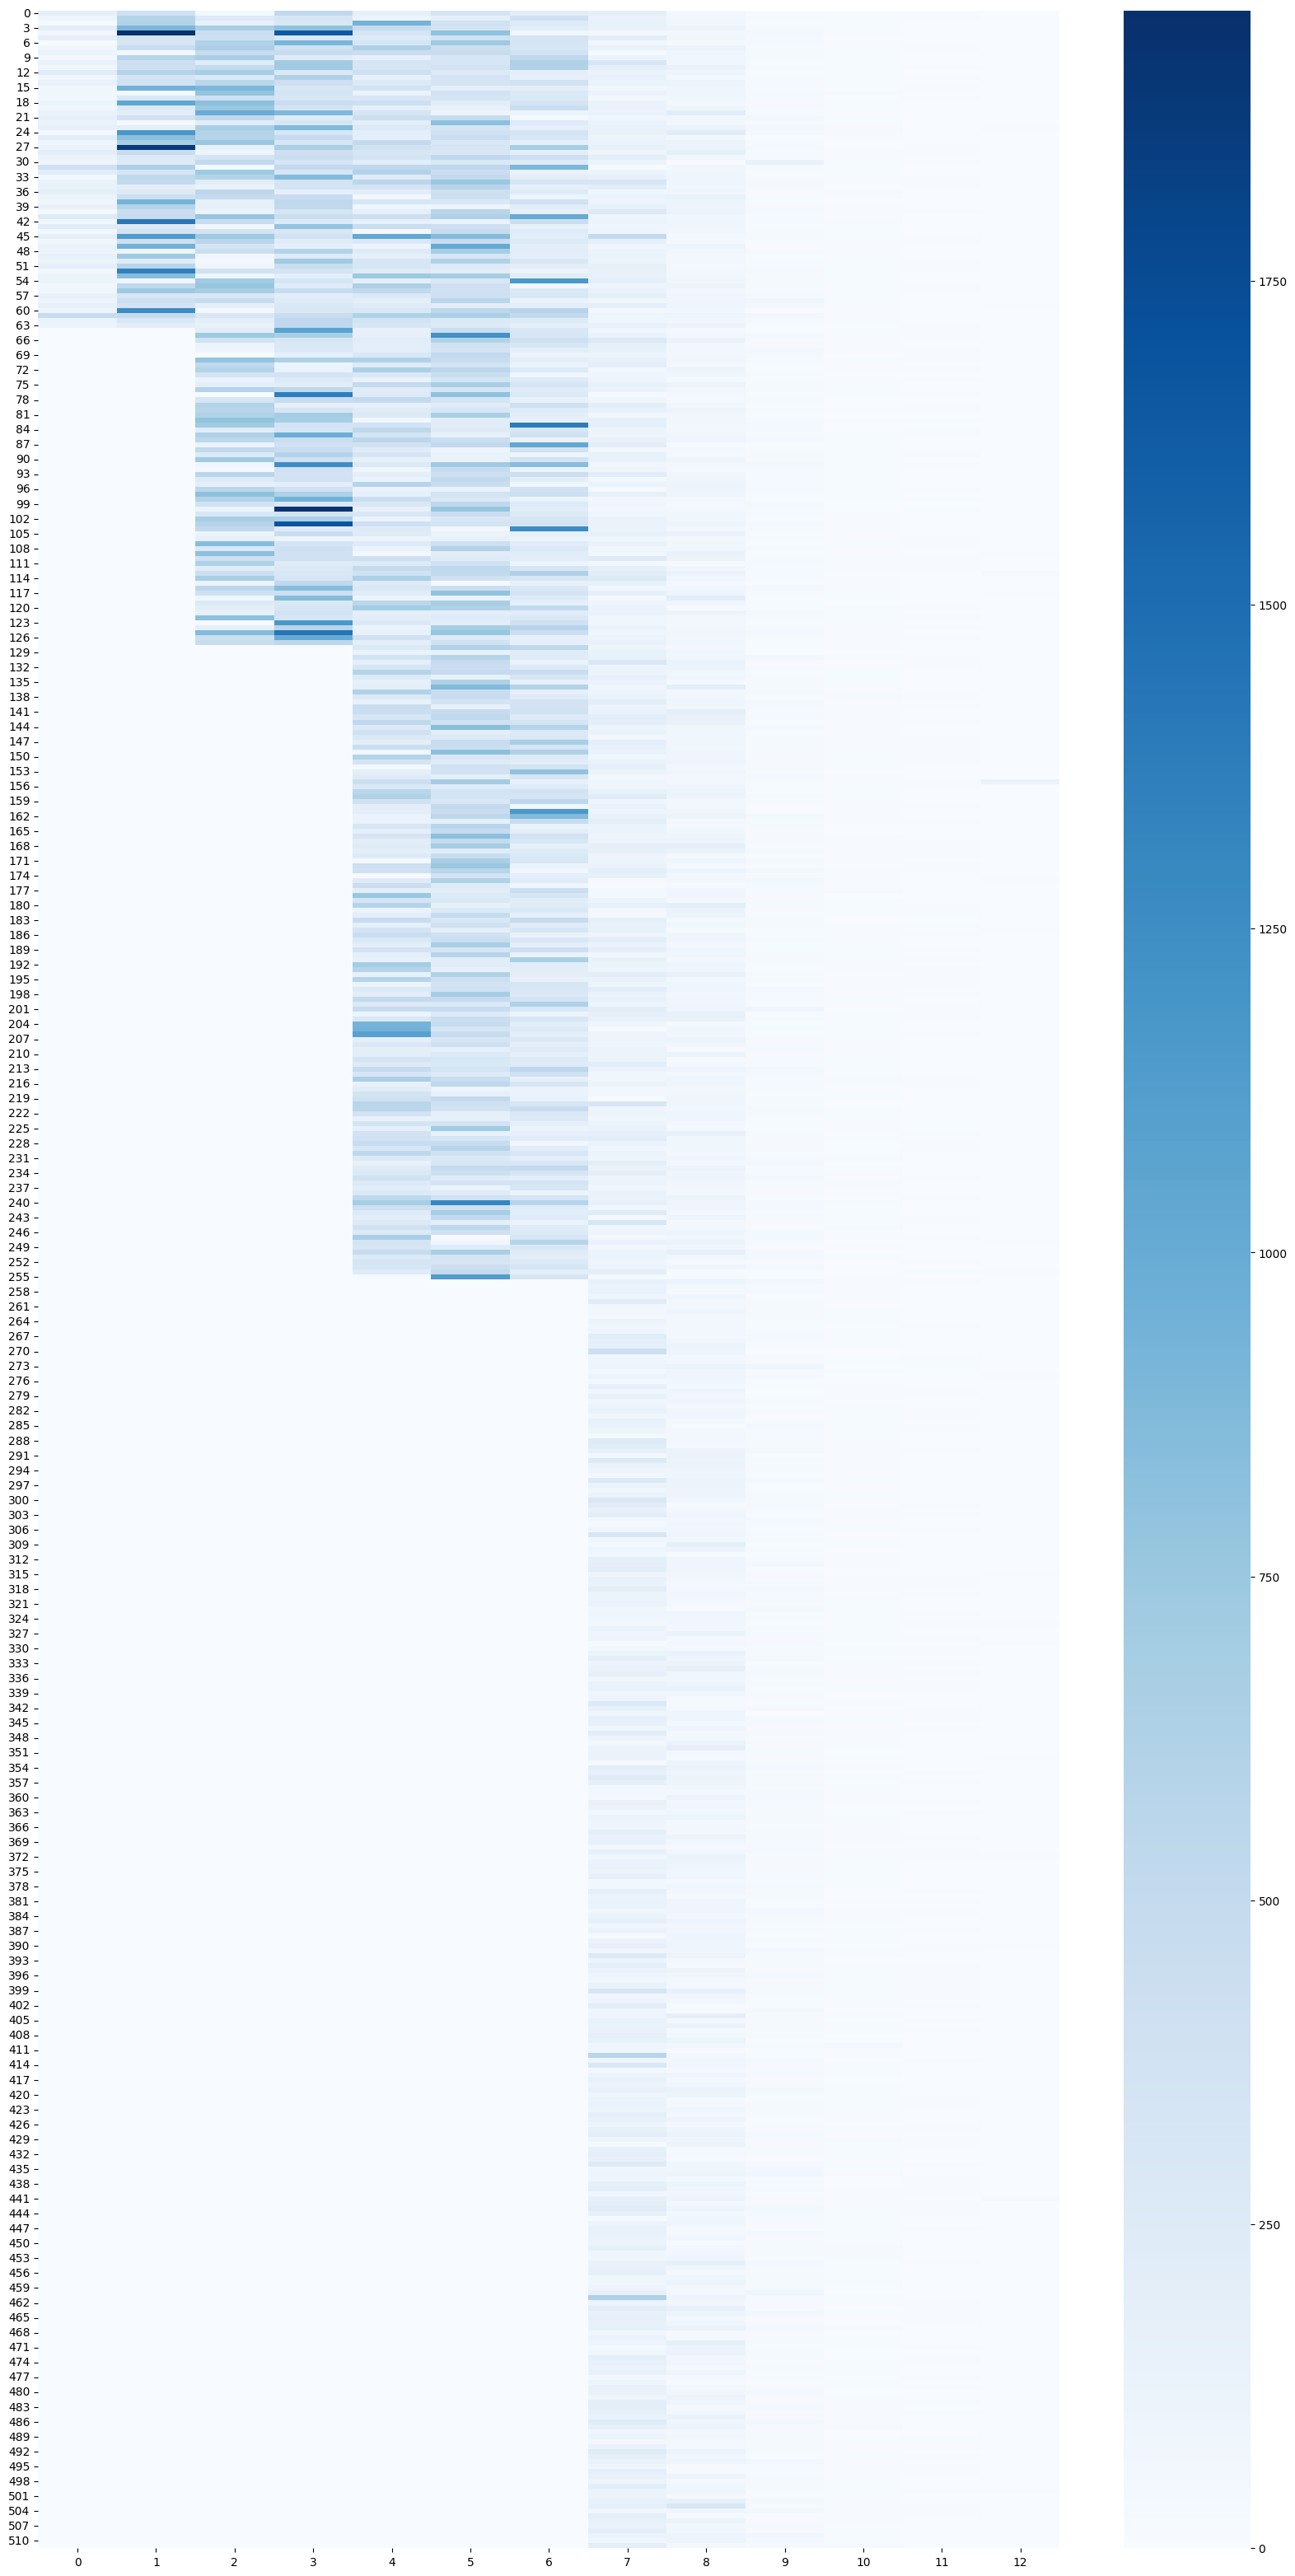

In [203]:
def get_footprint(pathway: dict[str,np.ndarray]):
    max_channels = max([len(layer) for layer in pathway.values()])
    heatmap = np.zeros((max_channels, len(pathway)))
    for i, layer in enumerate(pathway):
        heatmap[:len(pathway[layer]), i] = pathway[layer]
        
    return heatmap
    
heatmap = get_footprint(pathways[0])

fig = plt.figure(figsize=(20, 40))
sns.heatmap(heatmap, cmap='Blues')

# Similar layer activations

In [ ]:
class bbox_select():
    %matplotlib notebook 


    def __init__(self,im):
        self.logs = []
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),7)
        return img

    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
            self.fig
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)



Button(description='Disconnect mpl', style=ButtonStyle())

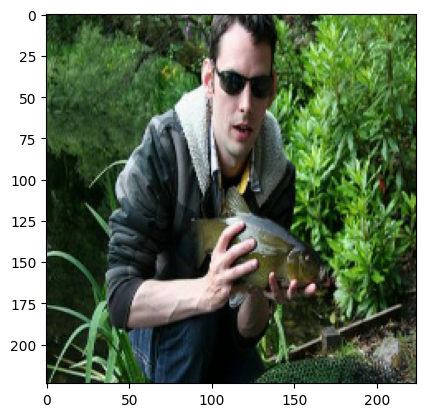

In [211]:
input_img = dataset.take(1).as_numpy_iterator().next()[0][0]

image = ((input_img / 2.0 + 0.5) * 255).astype(np.uint8).squeeze()

bs = bbox_select(image)

In [212]:
%matplotlib inline

In [ ]:
bs.selected_points

[]

In [ ]:
selected_points = [[88.68750000000004, 124.91287878787875],
 [108.08143939393942, 123.09469696969694],
 [111.71780303030307, 107.33712121212119],
 [129.29356060606062, 120.6704545454545],
 [164.4450757575758, 152.18560606060603],
 [141.41477272727275, 165.51893939393938],
 [106.8693181818182, 160.67045454545453],
 [87.47537878787882, 156.42803030303028],
 [74.74810606060608, 134.00378787878785],
 [86.2632575757576, 114.00378787878785]]

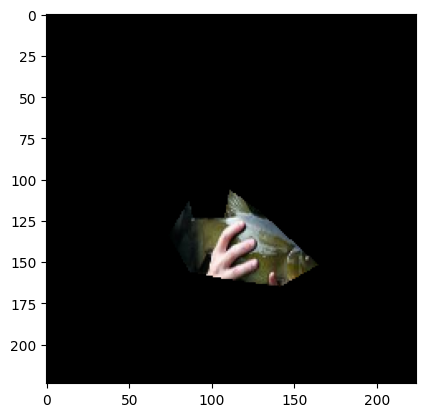

In [213]:
def is_numpy_type(value):
    return hasattr(value, 'dtype')

def apply_mask(img, mask_img):
    if len(img.shape) == 4:
        print('herle')
        return np.multiply(img, mask_img[np.newaxis,:,:,np.newaxis])
    elif len(img.shape) == 3:
        return np.multiply(img, mask_img[:,:,np.newaxis])
    elif len(img.shape) == 2:
        return np.multiply(img, mask_img[:,:])
    raise Exception
    
    
def apply_polygon_mask(image, polygon):
    mask = Image.new("L", (image.shape[0], image.shape[1]), 0)
    draw = ImageDraw.Draw(mask)

    polygon_points = [(p[0].item() if is_numpy_type(p[0]) else p[0], p[1].item() if is_numpy_type(p[1]) else p[1]) for p in polygon]
    draw.polygon(polygon_points, outline=1, fill=1)

    mask_array = np.array(mask)

    return apply_mask(image, mask_array), mask_array

masked_img, mask_img = apply_polygon_mask(image, selected_points)
plt.imshow(masked_img)

In [214]:
mask_img[:,:,np.newaxis].shape

(224, 224, 1)

In [225]:
dataset = ds['train'].filter(
    lambda img, label: tf.equal(label, 0)
).map(
    lambda img, label: preprocess(
        (img, label), size=model.input.shape[1:3].as_list())
).batch(
    1
).take(5)

layers = ['block1_conv1',
          'block1_conv2',
          'block2_conv1',
          'block2_conv2',
          'block3_conv1',
          'block3_conv2',
          'block3_conv3',
          'block4_conv1',
          'block4_conv2',
          'block4_conv3',
          'block5_conv1',
          'block5_conv2',
          'block5_conv3',
          ]

    
def get_mask_activation_channels(mask_img, activations, threshold_fn=lambda layer, channel: channel>10):
    masked_activations = {layer:[] for layer in activations}
    activated_channels = {layer:[] for layer in masked_activations}
    for layer, val in activations.items():
        mask = tf.image.resize(mask_img[:,:,np.newaxis], val.shape[1:3], method=tf.image.ResizeMethod.BILINEAR).numpy().squeeze()
        for channel_i, channel in enumerate(val[0].transpose(2,0,1)):
            masked_val = apply_mask(channel, mask)
            masked_val_summary = summary_fn_image(masked_val[np.newaxis,:,:,np.newaxis]).squeeze()
            masked_activations[layer].append(masked_val_summary.item())
        
        for channel_i, channel in enumerate(masked_activations[layer]):
            if threshold_fn(masked_activations[layer], channel):
                activated_channels[layer].append(channel_i)
    
#     return masked_activations
    return activated_channels

activations = keract.get_activations(model, input_img[np.newaxis,:,:,:], layer_names=layers)

def thresh_fn(layer, channel):
    return channel > np.percentile(layer, 99)

activated_channels = get_mask_activation_channels(mask_img, activations, thresh_fn)
pprint(activated_channels)
pprint({key:len(val) for key,val in activated_channels.items()})

# heatmap = get_footprint(masked_activations)
# fig = plt.figure(figsize=(20, 40))
# sns.heatmap(heatmap[:,10:], cmap='Blues')

# for (imgs, labels) in tqdm(dataset):
#     cur_activation = keract.get_activations(model, imgs, layer_names=layers)
#     print(cur_activation)
#     break
    
#     activations = convert_activations_to_vals(activations)
#     for i, label in enumerate(labels):
#         label = label.numpy()
#         for layer in layers:
#             cur_pathways[label][layer] += activations[layer][i]

    

{'block1_conv1': [61],
 'block1_conv2': [4],
 'block2_conv1': [18, 125],
 'block2_conv2': [4, 103],
 'block3_conv1': [41, 56, 126],
 'block3_conv2': [36, 213, 233],
 'block3_conv3': [64, 145, 153],
 'block4_conv1': [142, 168, 342, 383, 412, 444],
 'block4_conv2': [152, 334, 338, 359, 363, 368],
 'block4_conv3': [208, 221, 260, 361, 367, 454],
 'block5_conv1': [67, 87, 196, 371, 490, 492],
 'block5_conv2': [70, 226, 252, 337, 393, 506],
 'block5_conv3': [113, 155, 171, 200, 316, 441]}
{'block1_conv1': 1,
 'block1_conv2': 1,
 'block2_conv1': 2,
 'block2_conv2': 2,
 'block3_conv1': 3,
 'block3_conv2': 3,
 'block3_conv3': 3,
 'block4_conv1': 6,
 'block4_conv2': 6,
 'block4_conv3': 6,
 'block5_conv1': 6,
 'block5_conv2': 6,
 'block5_conv3': 6}


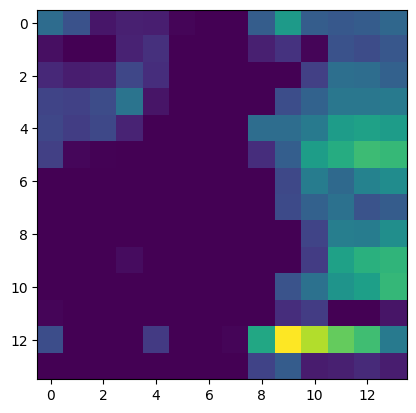

In [216]:
plt.imshow(activations['block5_conv1'][0,:,:,66])

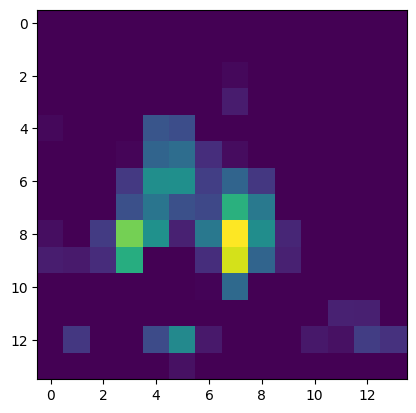

In [217]:
plt.imshow(activations['block5_conv1'][0,:,:,67])

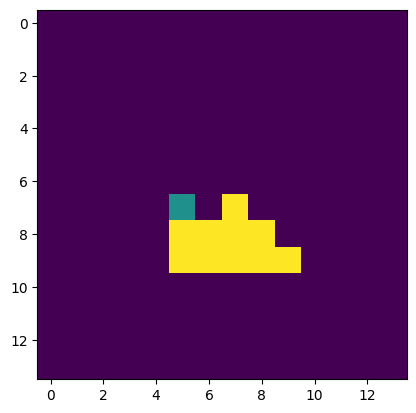

In [218]:
resized_mask = tf.image.resize(mask_img[:,:,np.newaxis], size=activations['block5_conv1'][0,:,:,66].shape, method=tf.image.ResizeMethod.BILINEAR).numpy().squeeze()
plt.imshow(resized_mask)

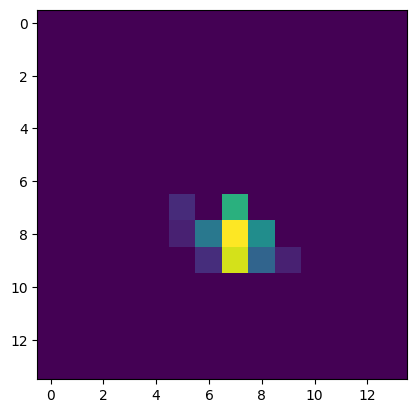

In [219]:
masked_channel = apply_mask(activations['block5_conv1'][0,:,:,67], resized_mask)
plt.imshow(masked_channel)

In [220]:
summary_fn_image(masked_channel[np.newaxis,:,:,np.newaxis]).squeeze()

array(18.440287, dtype=float32)

In [221]:
summary_fn_image(activations['block5_conv1'][0,:,:,67][np.newaxis,:,:,np.newaxis]).squeeze()

array(24.71509, dtype=float32)

In [222]:
summary_fn_image(apply_mask(activations['block5_conv1'][0,:,:,66], resized_mask)[np.newaxis,:,:,np.newaxis]).squeeze()

array(0., dtype=float32)

In [223]:
summary_fn_image(activations['block5_conv1'][0,:,:,66][np.newaxis,:,:,np.newaxis]).squeeze()

array(28.473248, dtype=float32)

In [228]:
TAKE = 50
dataset = ds['train'].filter(
    lambda img, label: tf.equal(label, 0)
).map(
    lambda img, label: preprocess(
        (img, label), size=model.input.shape[1:3].as_list())
).batch(
    BATCH_SIZE
).take(TAKE)

In [229]:
def subtract_pathways(pathway1, pathway2):
    return {layer: pathway1[layer].squeeze() - pathway2[layer].squeeze() for layer in pathway1}

In [230]:
activations['block1_conv1'].shape

(1, 224, 224, 64)

Text(0.5, 1.0, 'Example input Activation of block5_conv1')

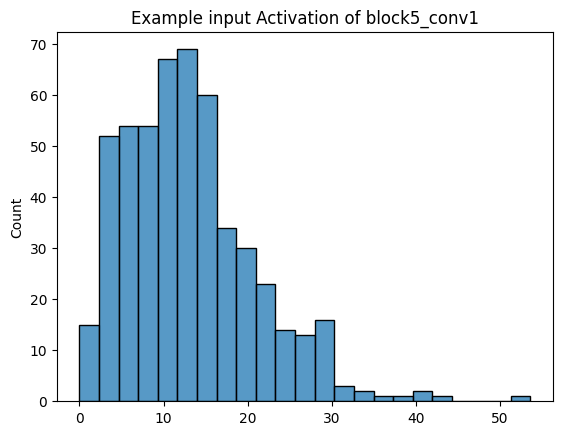

In [231]:
sns.histplot(summary_fn_image(activations['block5_conv1'])[0])
plt.title('Example input Activation of block5_conv1')

<Axes: title={'center': 'Average Activations of block5_conv1'}, ylabel='Count'>

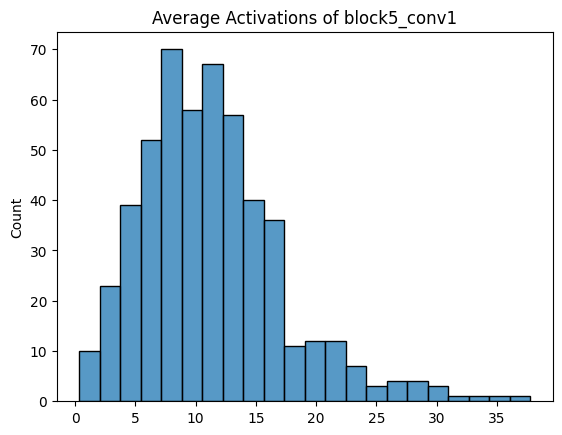

In [232]:
plt.title('Average Activations of block5_conv1')
sns.histplot(pathways[9]['block5_conv1'])

In [233]:
pathways[0]['block5_conv1'].shape

(512,)

In [234]:
activations_l2 = convert_activations_to_vals(activations)
activations_l2['block5_conv1'].shape

(1, 512)

In [235]:
pathways[0]['block5_conv1'].shape

(512,)

In [236]:
subtract_pathways(activations_l2, pathways[0])['block5_conv1'].shape

(512,)

<Axes: ylabel='Count'>

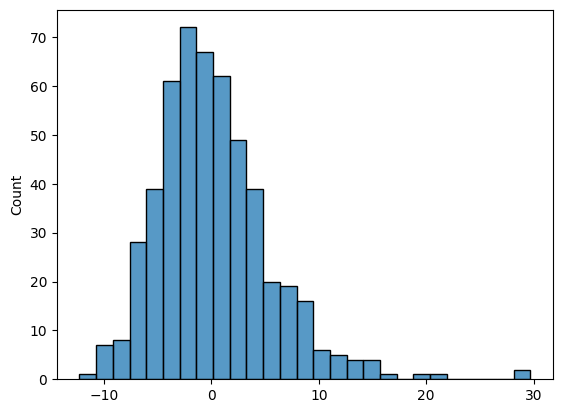

In [237]:
sns.histplot(subtract_pathways(activations_l2, pathways[0])['block5_conv1'])

/tmp/ipykernel_2976/1712242808.py:10: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap.T / heatmap.T.sum(axis=0)


<Axes: >

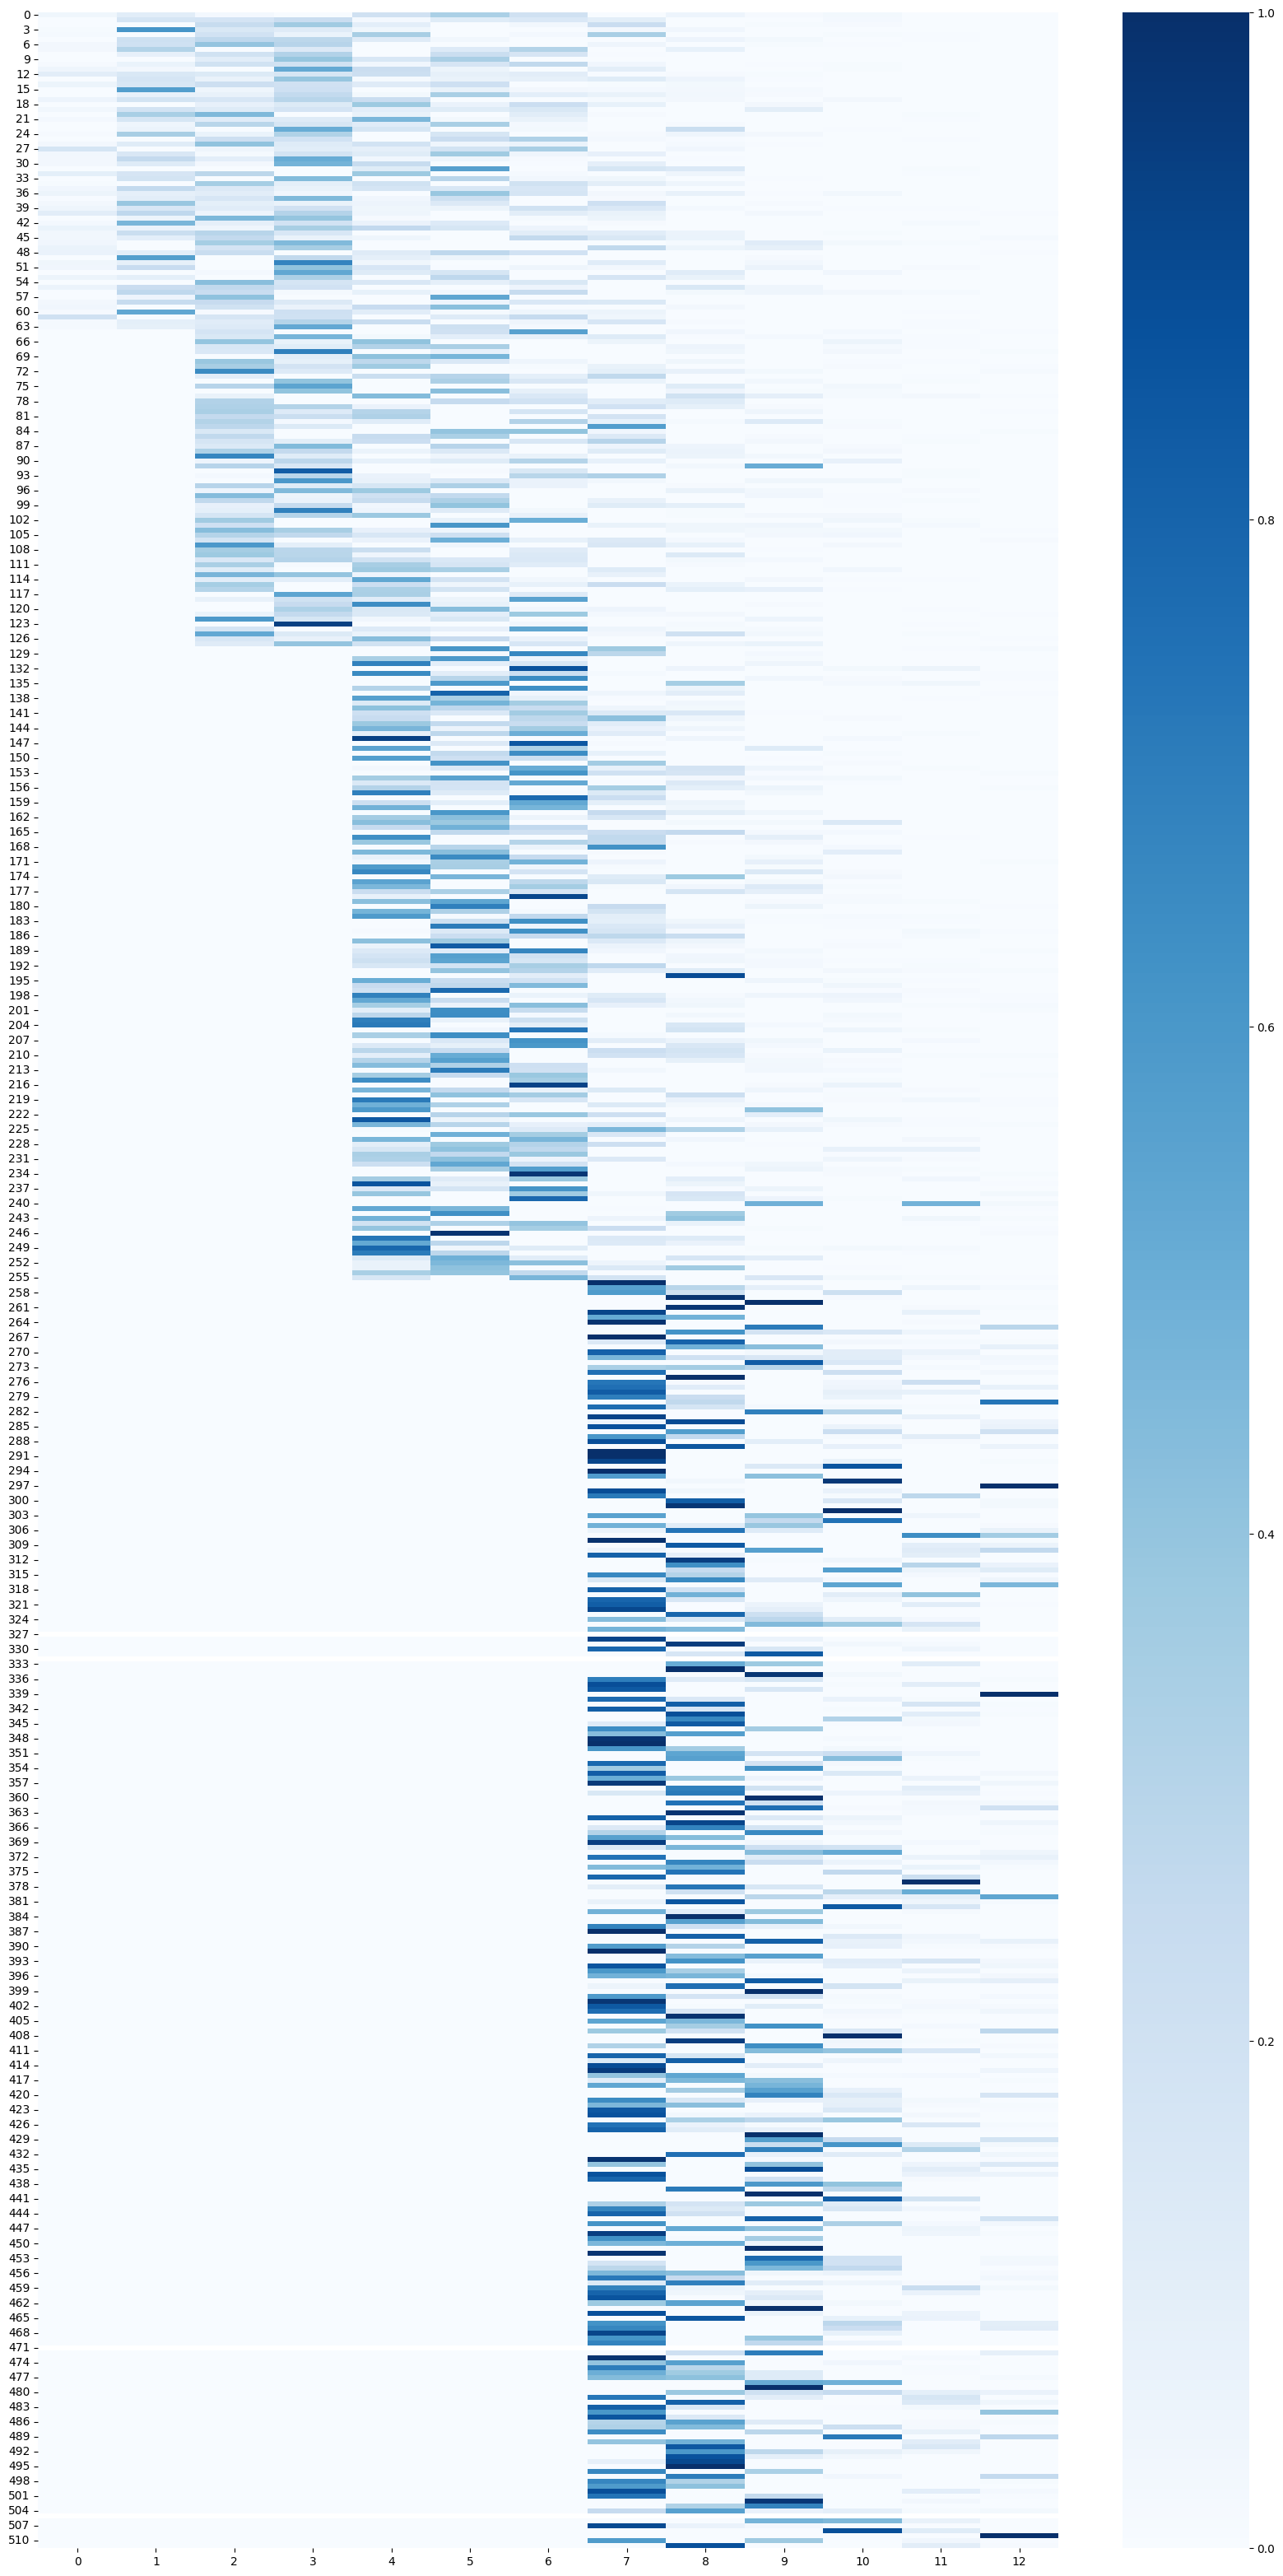

In [249]:
sub_activations = subtract_pathways(activations_l2, pathways[0])
for layer in sub_activations:
    for i, channel in enumerate(sub_activations[layer]):
        if channel < 0:
            sub_activations[layer][i] = 0
            
        
heatmap= get_footprint(sub_activations)
# row wise normalization
heatmap = heatmap.T / heatmap.T.sum(axis=0)
heatmap = heatmap.T

fig = plt.figure(figsize=(20, 40))
sns.heatmap(heatmap, cmap='Blues')

In [ ]:
# Calculating class mean activation pathway: takes a long time so commenting out


# total_imgs = dataset.cardinality().numpy()*BATCH_SIZE

# print(dataset.cardinality().numpy(), total_imgs)


# layers = ['block1_conv1',
#           'block1_conv2',
#           'block2_conv1',
#           'block2_conv2',
#           'block3_conv1',
#           'block3_conv2',
#           'block3_conv3',
#           'block4_conv1',
#           'block4_conv2',
#           'block4_conv3',
#           'block5_conv1',
#           'block5_conv2',
#           'block5_conv3',
#           ]

# cur_pathways = {name: {layer: np.zeros(model.get_layer(name=layer).filters) for layer in layers} for name in range(len(ds_info.features['label'].names))}

# for (imgs, labels) in tqdm(dataset):
#     activations = keract.get_activations(model, imgs, layer_names=layers)
#     activations = convert_activations_to_vals(activations)
#     for i, label in enumerate(labels):
#         label = label.numpy()
#         for layer in layers:
#             cur_pathways[label][layer] += activations[layer][i]
            
# for label in cur_pathways:
#     for layer in cur_pathways[label]:
#         cur_pathways[label][layer] /= total_imgs

In [295]:
activations1['block1_conv1'].shape

(1, 224, 224, 64)

<Axes: >

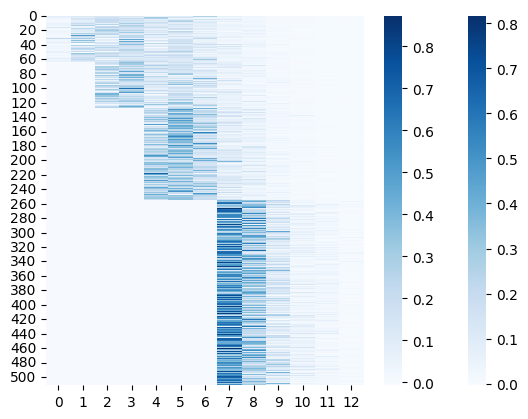

In [291]:
images = dataset.take(1).as_numpy_iterator().next()[0]
input_img1 = images[17]
input_img2 = images[10]
input_img1 = ((input_img1 / 2.0 + 0.5) * 255).astype(np.uint8).squeeze()
input_img2 = ((input_img2 / 2.0 + 0.5) * 255).astype(np.uint8).squeeze()

activations1 = keract.get_activations(model, input_img1[np.newaxis,:,:,:], layer_names=layers)
activations2 = keract.get_activations(model, input_img2[np.newaxis,:,:,:], layer_names=layers)

activation_summary1 = convert_activations_to_vals(activations1)
activation_summary2 = convert_activations_to_vals(activations2)

sub_activation1 = subtract_pathways(activation_summary1, pathways[1])
sub_activation2 = subtract_pathways(activation_summary2, pathways[1])


# for layer in sub_activation1:
#     for i, channel in enumerate(sub_activation1[layer]):
#         if channel < 0:
#             sub_activation1[layer][i] = 0

# for layer in sub_activation2:
#     for i, channel in enumerate(sub_activation2[layer]):
#         if channel < 0:
#             sub_activation2[layer][i] = 0
            
heatmap1 = get_footprint(sub_activation1)
heatmap1 = heatmap1.T / heatmap1.T.sum(axis=0)
heatmap1 = heatmap1.T

heatmap2 = get_footprint(sub_activation2)
heatmap2 = heatmap2.T / heatmap2.T.sum(axis=0)
heatmap2 = heatmap2.T


sns.heatmap(heatmap1, cmap='Blues')
sns.heatmap(heatmap2, cmap='Blues')

<Axes: >

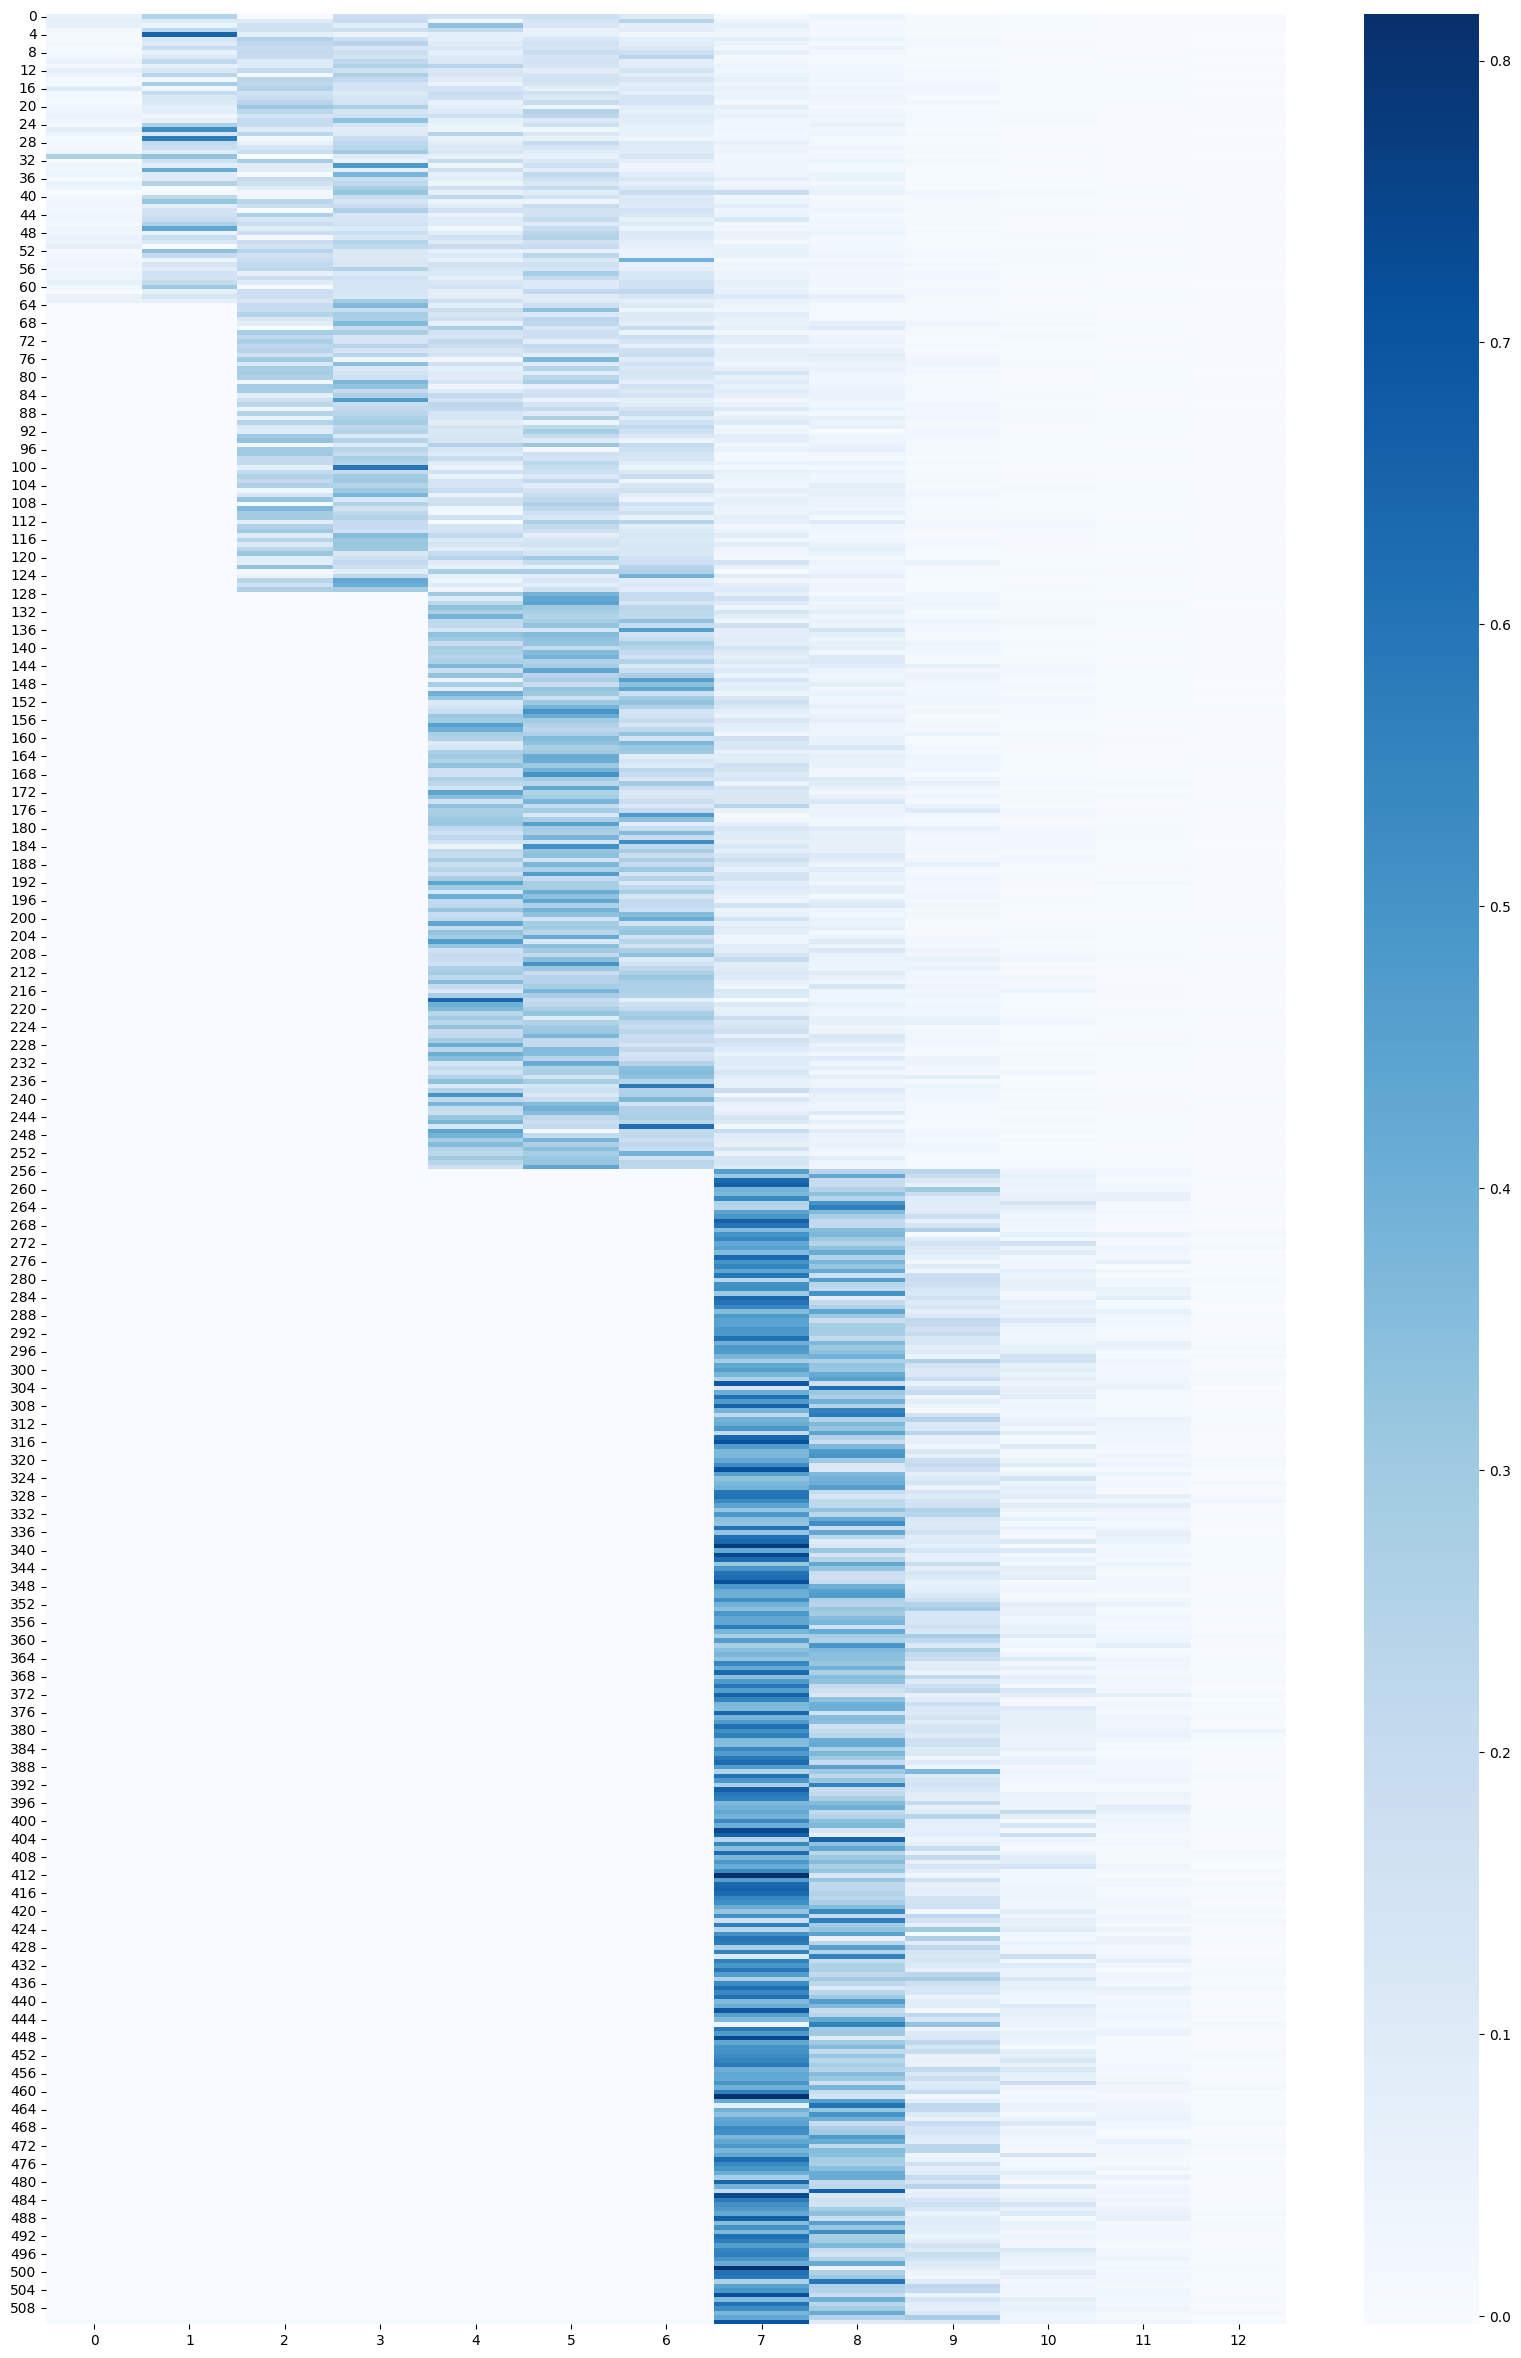

In [288]:
fig = plt.figure(figsize=(20, 30))
sns.heatmap(heatmap1, cmap='Blues')

<Axes: >

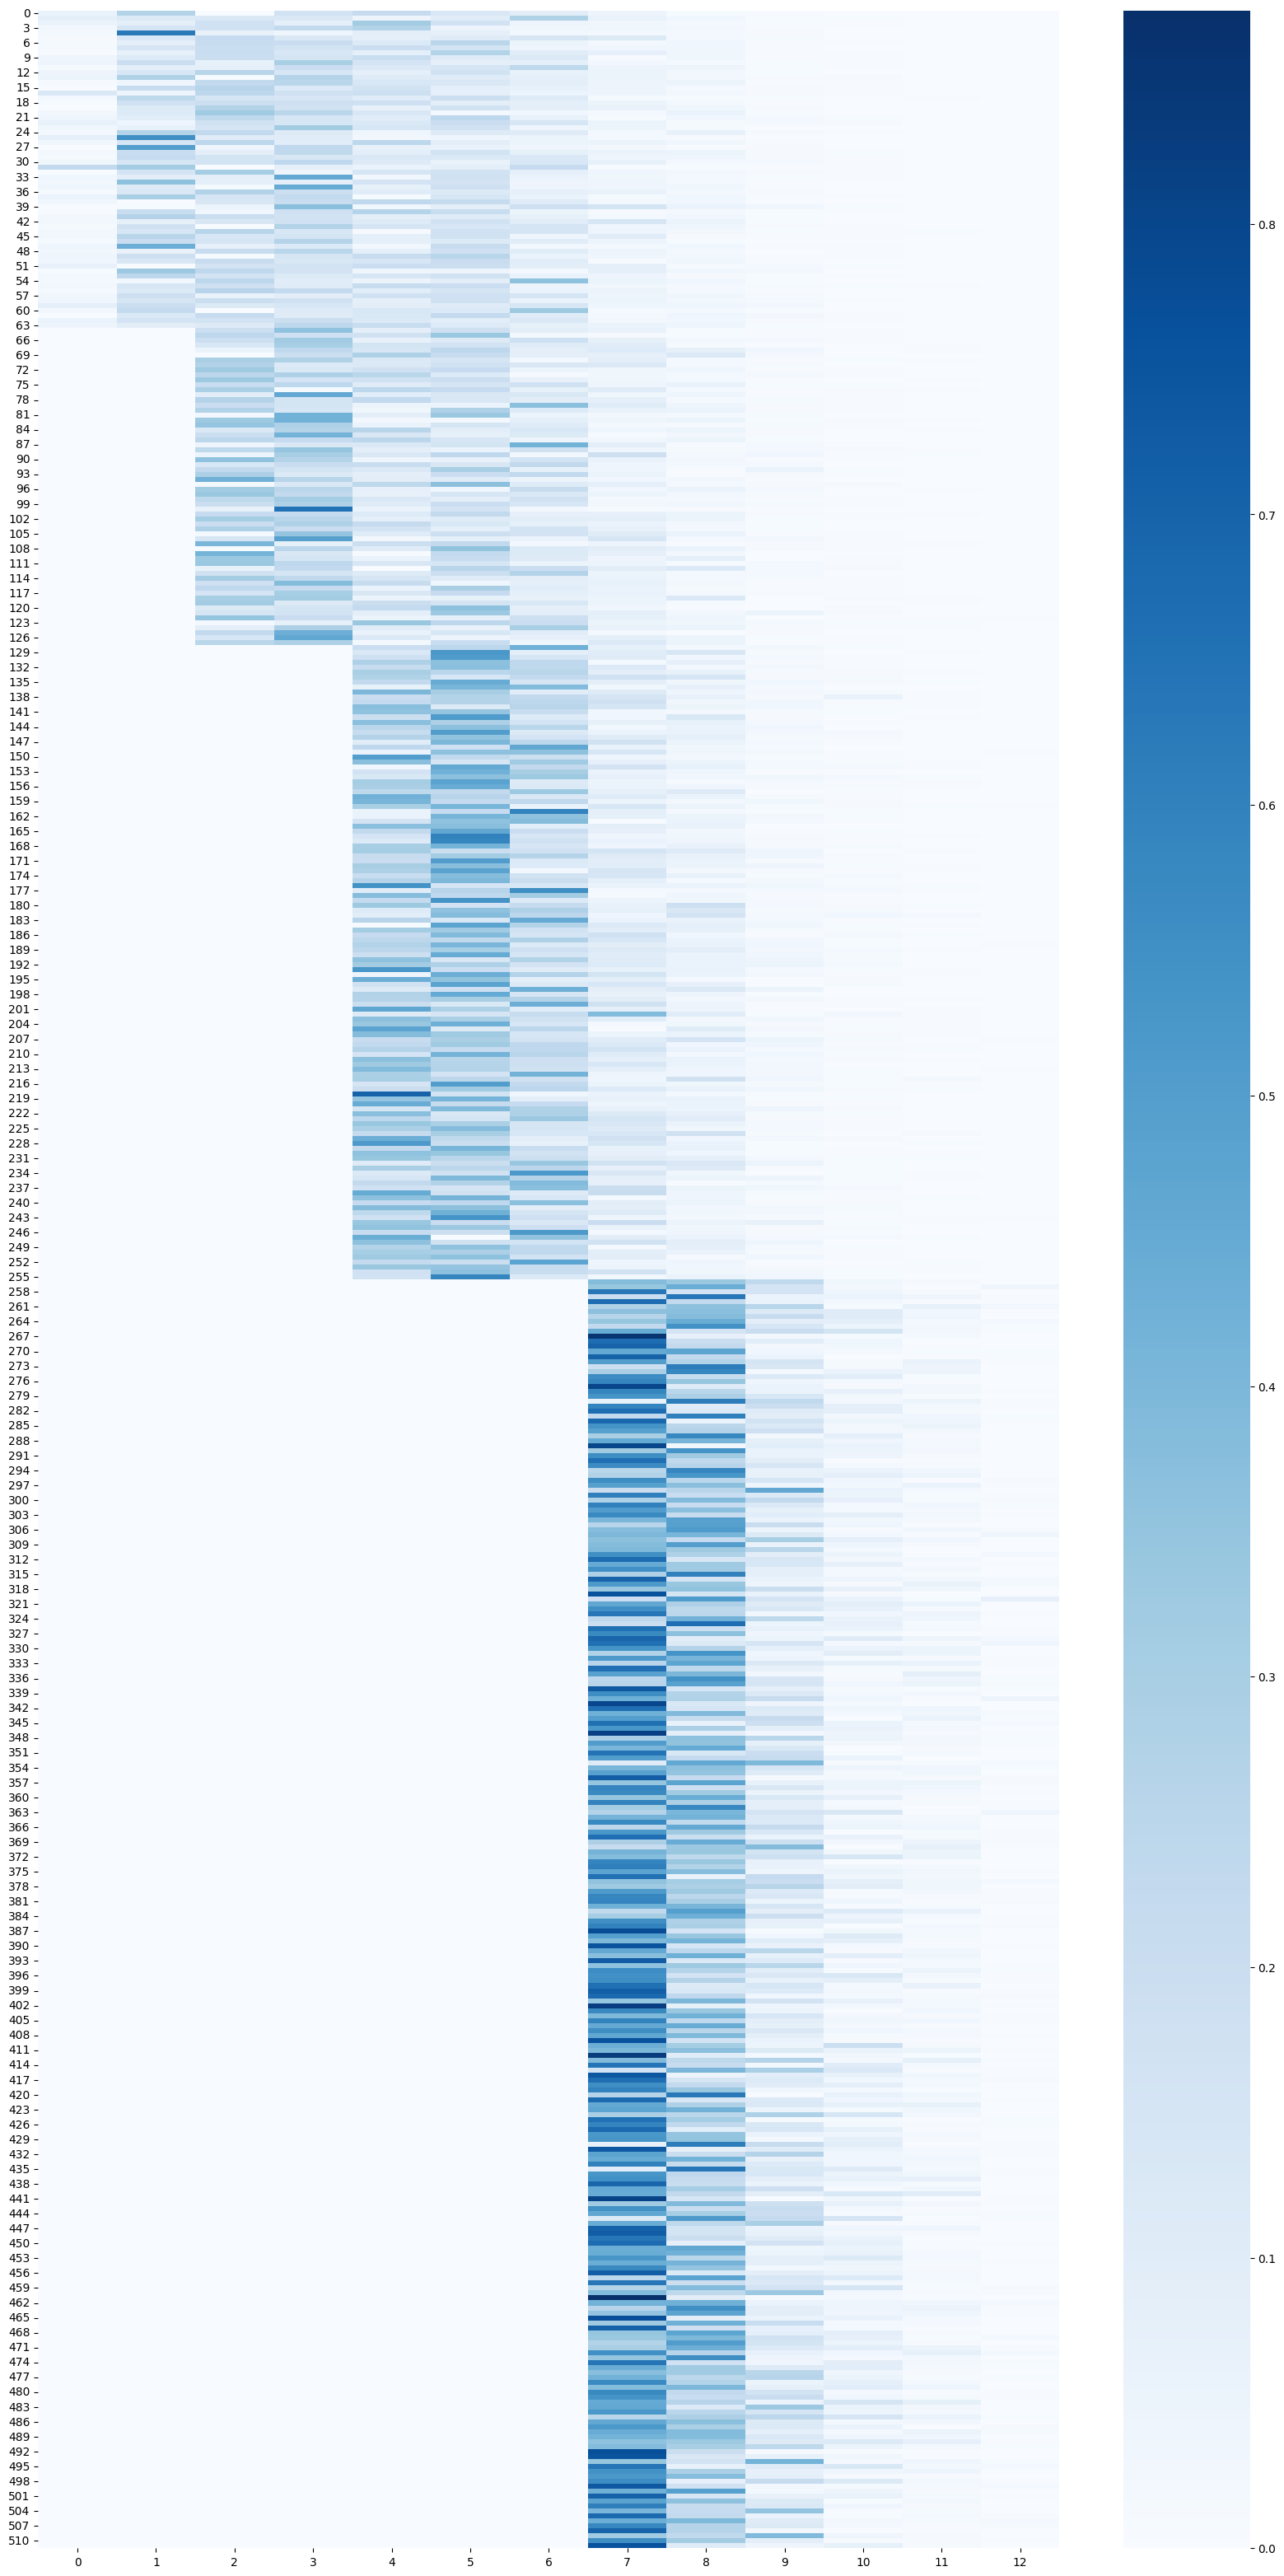

In [282]:
fig = plt.figure(figsize=(20, 40))
sns.heatmap(heatmap2, cmap='Blues')


In [276]:
pathways[0]['block5_conv1']

array([16.32325641, 15.98872092,  8.27752228, 18.416086  , 12.93227644,
        4.67986906, 17.53372921, 10.79810455, 17.7306554 ,  8.88335229,
       10.83829169, 16.03435282, 18.67607629, 13.06980459, 17.36976945,
        8.9144264 , 23.19530227,  7.47443106, 12.26005618, 18.37716772,
        7.7325315 , 15.53373494, 19.27106742, 25.22584172, 25.50847688,
        8.53045837,  3.52938273,  7.01972469, 10.90175232, 13.4604659 ,
       15.72242589, 11.12056097, 21.270868  , 13.87822855, 16.15187944,
        5.6756526 , 25.35322815, 13.94827582,  2.92822328,  9.32146483,
       10.8194057 ,  9.09047311, 23.44343715, 16.32713539, 13.01191371,
       17.67032813, 15.06507563,  8.30822541, 10.63907882, 13.53952877,
       12.78141523, 18.44689676, 19.92278313, 20.79913189, 11.60526135,
       15.05667234, 13.76941822,  8.51047083, 16.10201503,  8.23490629,
        9.53240937, 13.85649746, 13.50908318,  3.02300702,  7.79681906,
       22.70677173, 13.63400162, 12.07944107, 10.82173874,  2.16

In [278]:
activation_summary2['block5_conv1']

array([[ 514.70215  ,  976.0658   ,  333.03625  ,  877.6712   ,
         819.87366  ,  419.52194  , 1069.3218   ,  420.23703  ,
         189.46179  ,  385.2817   , 1125.3792   ,  560.5153   ,
         227.7145   ,  708.18787  , 1288.6274   ,  447.1628   ,
         791.77985  ,   69.507065 ,  330.9046   ,  860.22046  ,
         223.18227  ,  871.08575  ,  470.58795  , 1945.9274   ,
        1060.2397   ,  166.67184  ,  261.04727  ,  683.8259   ,
          96.23501  , 1130.2415   , 1091.4761   ,  547.7041   ,
         701.3255   ,  231.63573  ,  566.01276  ,  262.594    ,
         561.28503  ,  731.2467   ,  117.13413  ,  498.7195   ,
         304.15784  ,  171.25887  , 2256.8718   ,  794.0302   ,
         917.5733   ,  589.51996  ,  133.72702  ,  752.5139   ,
          67.85971  ,  923.3539   ,  683.9243   ,  649.21344  ,
        1322.0999   , 1230.1953   ,  257.34485  ,  667.90045  ,
         680.3713   ,    0.       , 1189.2949   ,  554.71875  ,
         679.73346  ,  942.6449   ,  208

<Axes: ylabel='Count'>

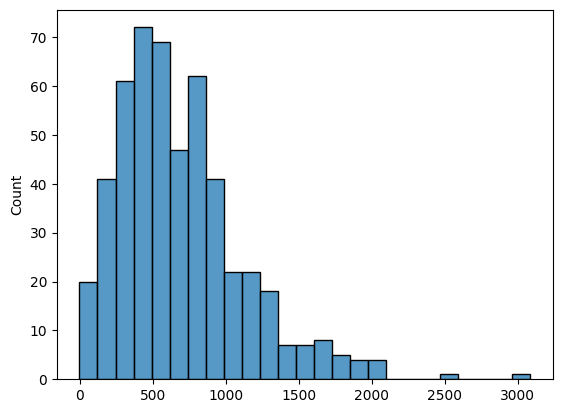

In [271]:
sns.histplot(subtract_pathways(activation_summary1, pathways[0])['block5_conv1'])